# Main Script Airline Dataset

First all required packages are loaded.

Note, that only well known packages are used and all functions, methods or procedures applied are well described on the websited of the respective packages.

For this script to run, following files are required. All files are provided and can also be recreated using the data script.

- 'DataFrame'
- 'clean_data'
- 'adjacency_matrix.csv'
- 'test.csv'


In [1]:
# import all required packages
import time
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

import networkx as nx
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

import dgl
import dgl.nn as dglnn

import torch
import torch.nn as nn
import torch.nn.functional as F
from sage import SAGEConv

import tqdm

import sklearn.metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

Using backend: pytorch


The normalization function for scaling the data within the range between 1 - 5 is defined below

In [2]:
# used for scaling non-ordinal data within the range of 1 - 5 
def normalize(x):
    return (x-x.min())/(x.max()-x.min()) * (5-1) + 1

The following function is the L2-normalization applied in the GraphSage model

In [3]:
# l2 normalization of GNN layer outputs after activation function
def norm(x):
    return F.normalize(x, p=2, dim=-1)

Norm = norm

## Load and Inspect the Data

Below a general overview of the dataset is gained.

In [4]:
df = pd.read_csv('DataFrame')
X = pd.read_csv('clean_data')

In [5]:
df['Type of Travel'].value_counts(normalize=True)

Business travel    0.689167
Personal Travel    0.310833
Name: Type of Travel, dtype: float64

In [6]:
X.drop(columns=['Unnamed: 0'],inplace=True)
# Adjust coding of Class, such that range is from 1-3. Was 0-2 before for the MAG generation process
X.Class = X.Class.apply(lambda x: 1 if x == 0 else(2 if x == 1 else 3))
X

Gender  Customer Type  Age  Type of Travel  Class  Flight Distance  \
0          1              0   69               0      1              964   
1          0              0   55               1      3              240   
2          1              0   51               1      3             2672   
3          0              1   27               1      1              495   
4          0              0   12               0      1              462   
...      ...            ...  ...             ...    ...              ...   
5995       1              0   49               0      1             1587   
5996       1              0   33               0      1              588   
5997       0              0   50               0      1             2358   
5998       0              0   35               0      1              672   
5999       0              0   32               0      3              397   

      Inflight wifi service  Departure/Arrival time convenient  \
0                         3                                  2   
1                         2                                  5   
2                         5                                  5   
3                         2                                  3   
4                         2                                  4   
...                     ...                                ...   
5995                      3                                  4   
5996                      2                                  5   
5997                      1                                  4   
5998                      2                                  3   
5999                      3                                  4   

      Ease of Online booking  Gate location  ...  Seat comfort  \
0                          3              3  ...             2   
1                          5              5  ...             2   
2                          5              5  ...             1   
3                          2              2  ...             3   
4                          2              3  ...             2   
...                      ...            ...  ...           ...   
5995                       3              4  ...             5   
5996                       2              3  ...             5   
5997                       1              5  ...             4   
5998                       2              2  ...             5   
5999                       3              1  ...             4   

      Inflight entertainment  On-board service  Leg room service  \
0                          5                 5                 3   
1                          1                 1                 2   
2                          4                 4                 4   
3                          3                 4                 4   
4                          2                 3                 4   
...                      ...               ...               ...   
5995                       4                 4                 3   
5996                       5                 5                 3   
5997                       4                 4                 5   
5998                       5                 1                 1   
5999                       4                 4                 2   

      Baggage handling  Checkin service  Inflight service  Cleanliness  \
0                    5                1                 5            3   
1                    3                2                 3            2   
2                    4                5                 4            3   
3                    3                4                 2            3   
4                    2                2                 1            2   
...                ...              ...               ...          ...   
5995                 5                3                 4            5   
5996                 5                5                 5            5   
5997                 4  

In [7]:
# Distribution of Gender in the data
X.Gender.value_counts(normalize=True)

1    0.507667
0    0.492333
Name: Gender, dtype: float64

<Figure size 2160x2160 with 0 Axes>

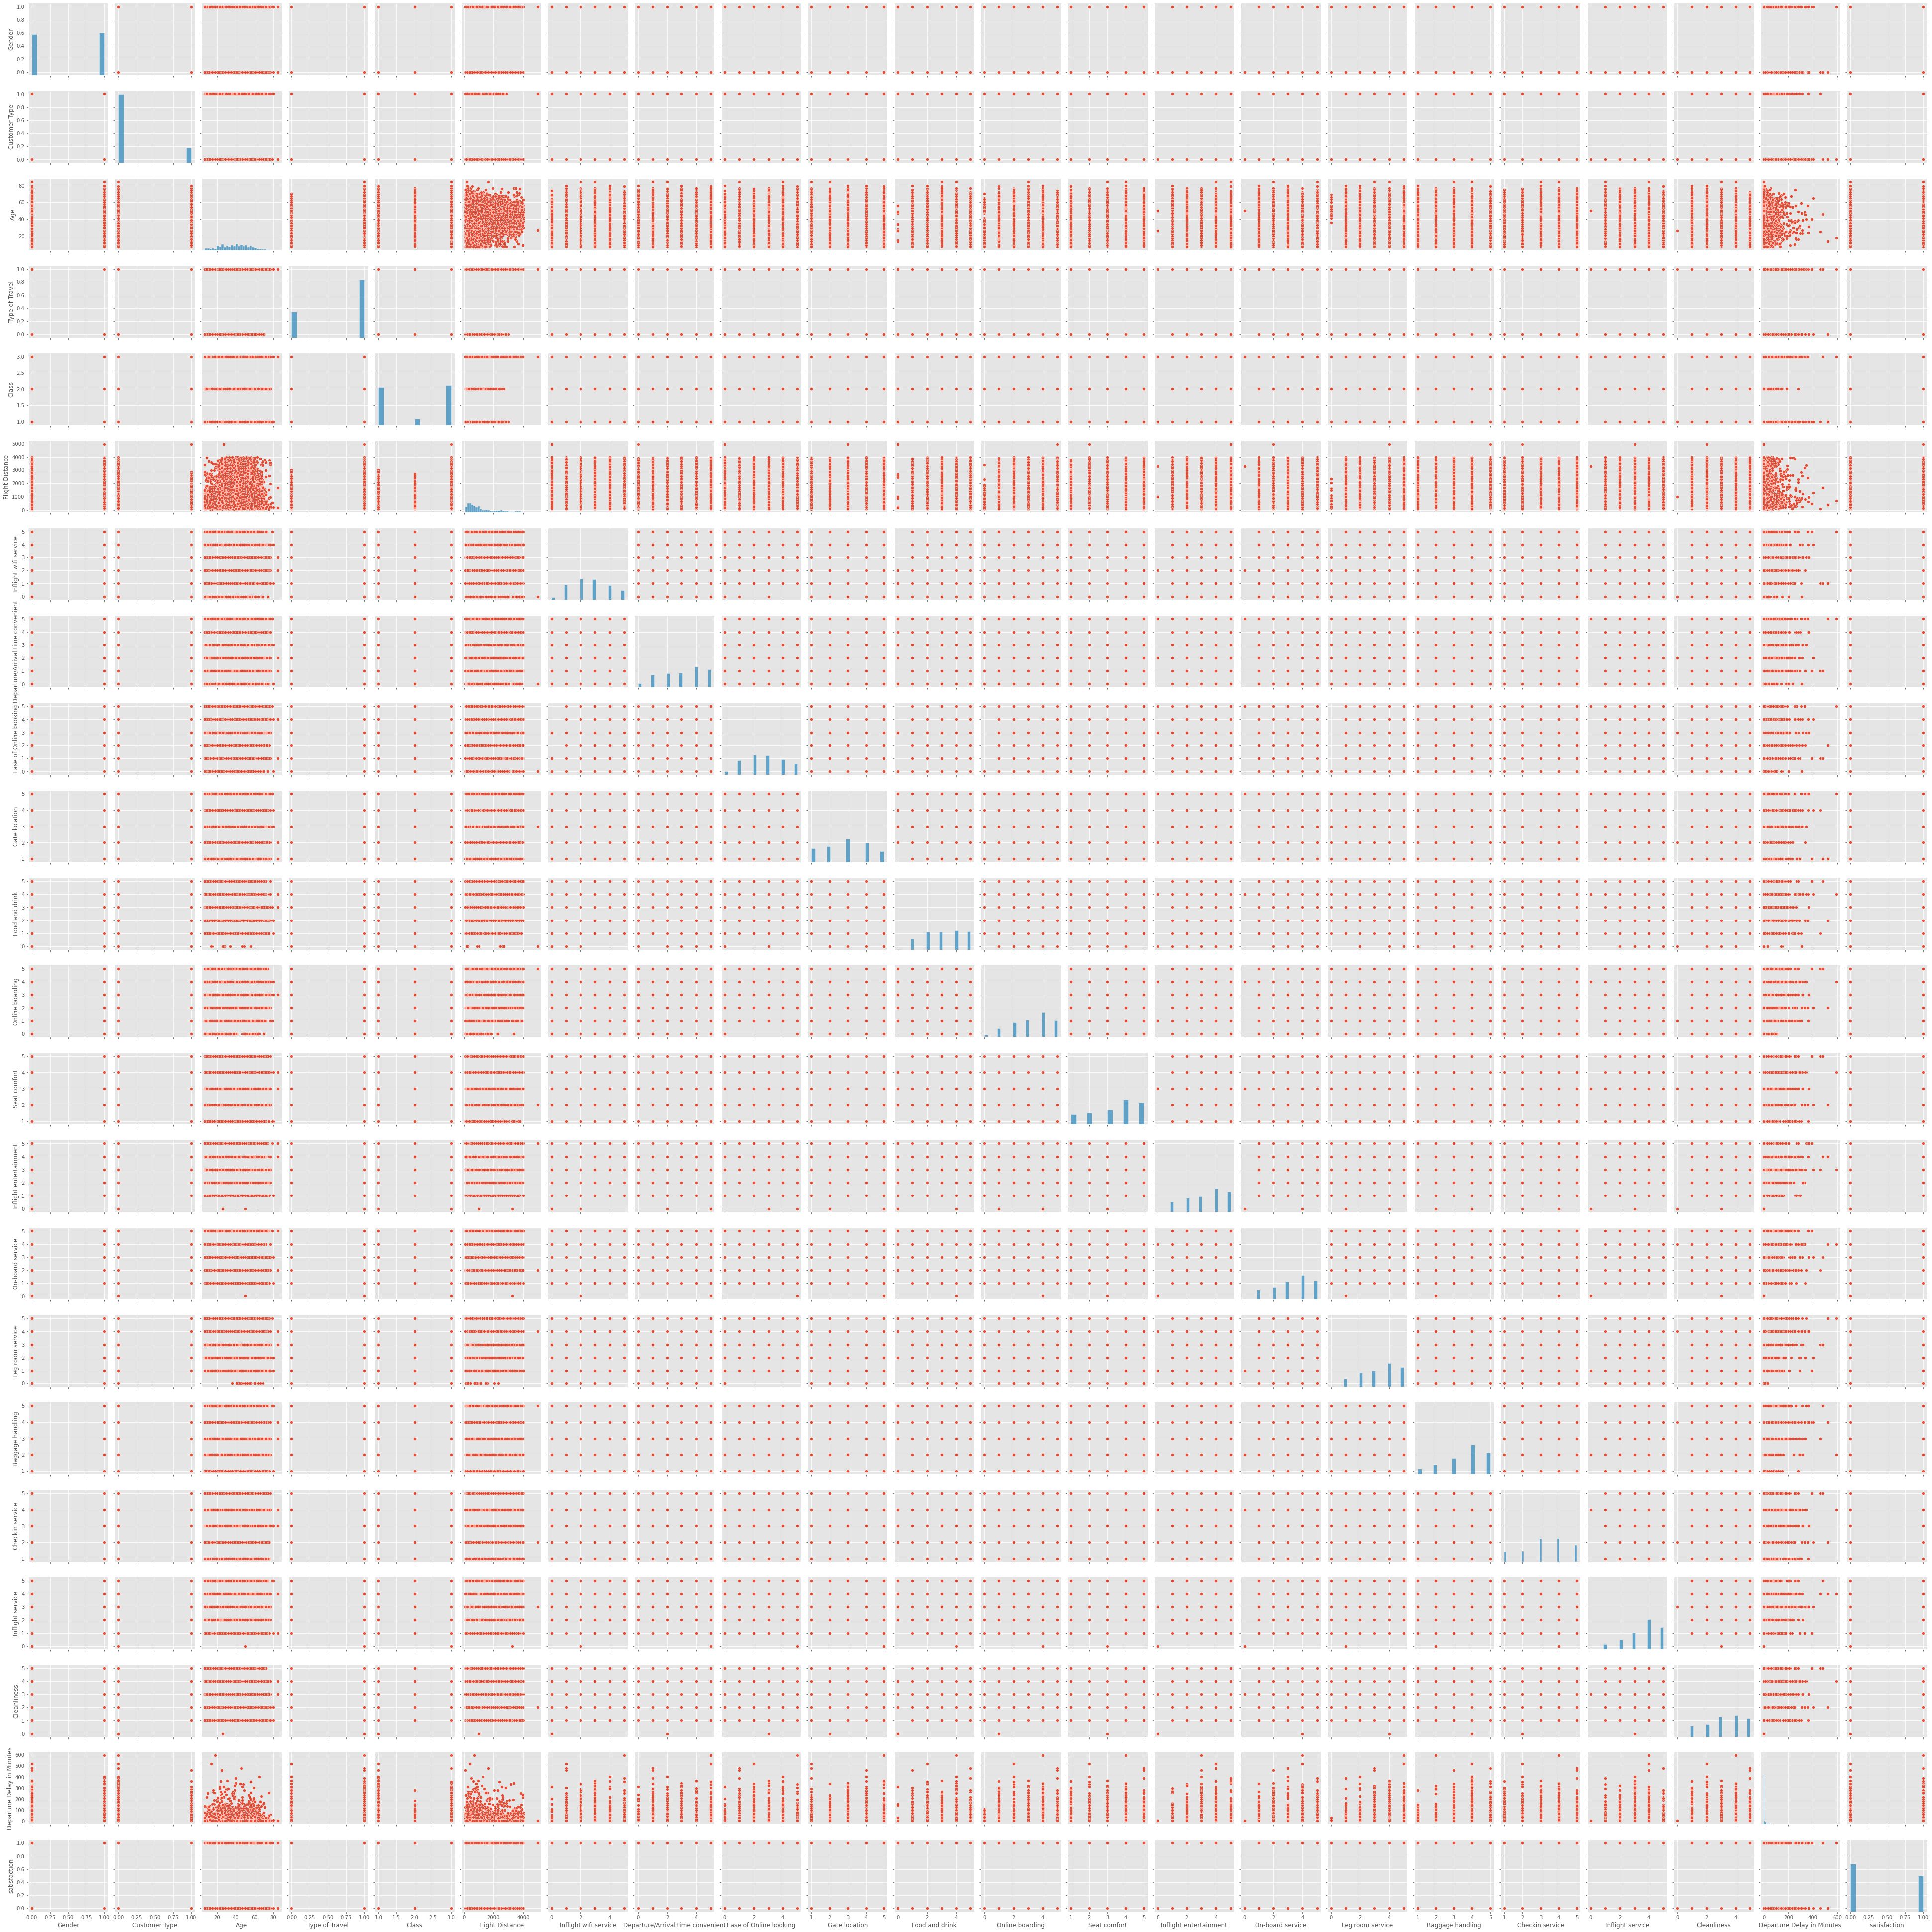

In [8]:
# Pairplot of ht entire dataset
plt.figure(figsize=(30,30))
sns.pairplot(X)
plt.show()

In [9]:
# Can be used to investigate the value counts for every category given the typ of travel
bus = (X['Type of Travel'] == 1)
pers = (X['Type of Travel'] == 0)
X[pers]['Gate location'].value_counts()

3    665
4    460
2    339
1    277
5    124
Name: Gate location, dtype: int64

In [10]:
X[bus]['satisfaction'].describe()

count    4135.000000
mean        0.578718
std         0.493824
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: satisfaction, dtype: float64

## Load the Graph Generated in The Data Script

In [11]:
A = np.loadtxt('adjacency_matrix.csv',delimiter=',')

In [12]:
np.diag(A).sum()

0.0

In [13]:
G = nx.from_numpy_matrix(A)

In [14]:
nx.is_connected(G)

True

## Dummy Code and Normalize the Data

In [15]:
features = pd.Series(X.satisfaction) # separate label from features
x_var = X.drop(columns=['satisfaction'])
x_wd = pd.get_dummies(data=x_var,columns=['Customer Type','Type of Travel','Gender'])
x_wd[['Age','Departure Delay in Minutes','Flight Distance']] = normalize(x_wd[['Age','Departure Delay in Minutes','Flight Distance']])

## Load and Pre-Process the Test Data in the exact same way as the Training Data

In [16]:
# Load Test Data
df_test = pd.read_csv('test.csv',sep=',')
df_test = df_test.sample(n=6000)
df_test.drop(columns=['Unnamed: 0','id'],inplace=True)
df_test.Gender = df_test.Gender.apply(lambda x: 0 if x == 'Male' else 1)
df_test['Customer Type'] = df_test['Customer Type'].apply(lambda x: 0 if x == 'Loyal Customer' else 1)
df_test['Type of Travel'] = df_test['Type of Travel'].apply(lambda x: 0 if x == 'Personal Travel' else 1)
df_test['Class'] = df_test['Class'].apply(lambda x: 0 if x == 'Eco' else(1 if x == 'Eco Plus' else 2))
df_test['satisfaction'] = df_test['satisfaction'].apply(lambda x: 0 if x == 'neutral or dissatisfied' else 1)
df_test.reset_index(drop=True,inplace=True)
df_test.drop(columns=['Arrival Delay in Minutes'],inplace = True)

In [17]:
TEST = df_test.copy(deep=True)

In [18]:
test_gen = TEST[['Gender','Customer Type','Age','Type of Travel','Class']].copy(deep=True)
test_gen.Age = test_gen.Age.apply(lambda x: 0 if x < 26 else(1 if x < 39 else(2 if x < 50 else 3)))

In [19]:
TEST.Class = TEST.Class.apply(lambda x: 1 if x == 0 else(2 if x == 1 else 3))

In [20]:
xx = TEST.drop(columns=['satisfaction'])
xx_dummy = pd.get_dummies(data=xx,columns=['Customer Type','Type of Travel','Gender'])
xx_dummy[['Age','Departure Delay in Minutes','Flight Distance']] = normalize(xx_dummy[['Age','Departure Delay in Minutes','Flight Distance']])
yy = TEST.satisfaction

## Plot the Training- Validation Graph

In [21]:
pos = nx.spring_layout(G)

In [22]:
dissatisfied = df.index[df.satisfaction == 'neutral or dissatisfied'].tolist()
satisfied = df.index[df.satisfaction == 'satisfied'].tolist()

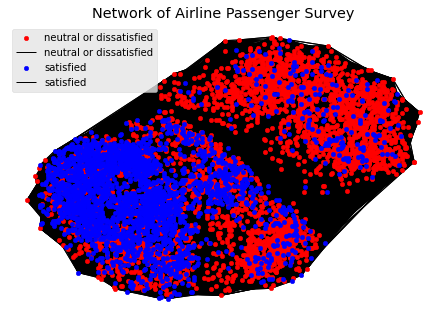

In [23]:
nx.draw(G,pos,nodelist=dissatisfied,node_size=20,node_color='r',label='neutral or dissatisfied')
nx.draw(G,pos,nodelist=satisfied,node_size=20,node_color='b',label='satisfied')
plt.title('Network of Airline Passenger Survey')
plt.legend()
plt.show()

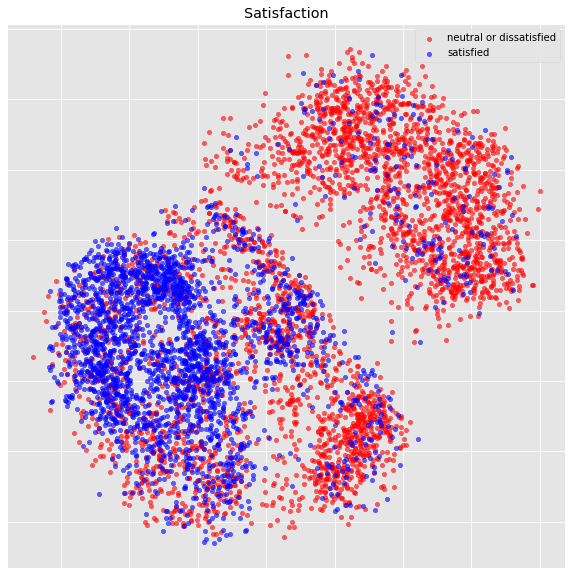

In [24]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=dissatisfied,node_size=20,node_color='r', alpha=0.6,label='neutral or dissatisfied')
nx.draw_networkx_nodes(G,pos,nodelist=satisfied,node_size=20,node_color='b', alpha=0.6,label='satisfied')
plt.legend()
plt.title('Satisfaction')
plt.show()

<AxesSubplot:>

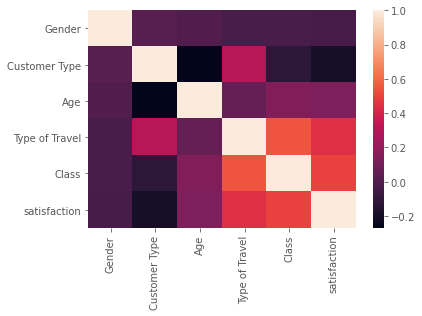

In [25]:
# correlation Map of the Attribute Variables and the Label
cormap_vars = X[['Gender','Customer Type','Age','Type of Travel','Class','satisfaction']]
cormap = cormap_vars.corr()
sns.heatmap(cormap)

In [26]:
male = df.index[df.Gender == 'Male'].tolist()
female = df.index[df.Gender == 'Female'].tolist()

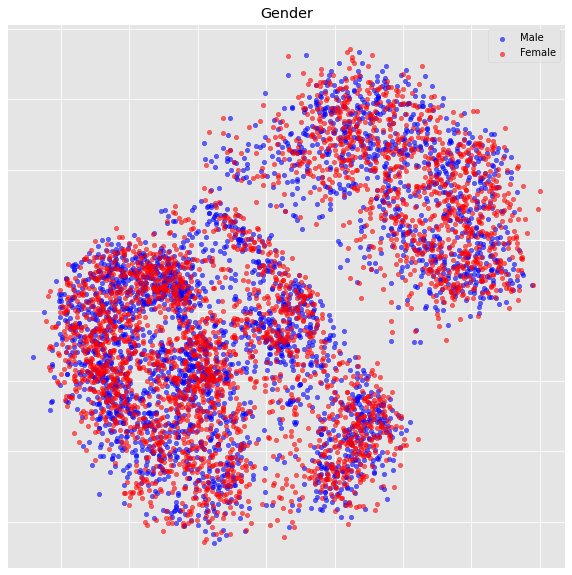

In [27]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=male,node_size=20,node_color='b', alpha=0.6,label='Male')
nx.draw_networkx_nodes(G,pos,nodelist=female,node_size=20,node_color='r', alpha=0.6,label='Female')
plt.legend()
plt.title('Gender')
plt.show()

In [28]:
loyal = df.index[df['Customer Type'] == 'Loyal Customer'].tolist()
disloyal = df.index[df['Customer Type'] == 'disloyal Customer'].tolist()

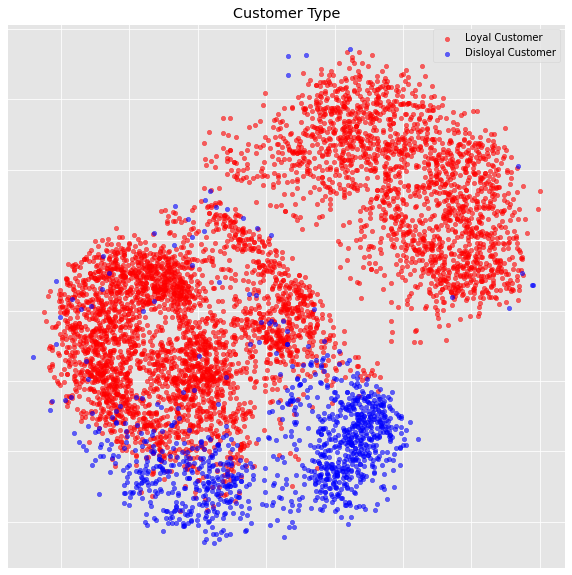

In [29]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=loyal,node_size=20,node_color='r', alpha=0.6,label='Loyal Customer')
nx.draw_networkx_nodes(G,pos,nodelist=disloyal,node_size=20,node_color='b', alpha=0.6,label='Disloyal Customer')
plt.legend()
plt.title('Customer Type')
plt.show()

In [30]:
eco = df.index[df.Class == 'Eco'].tolist()
eco_plus = df.index[df.Class == 'Eco Plus'].tolist()
bus = df.index[df.Class == 'Business'].tolist()

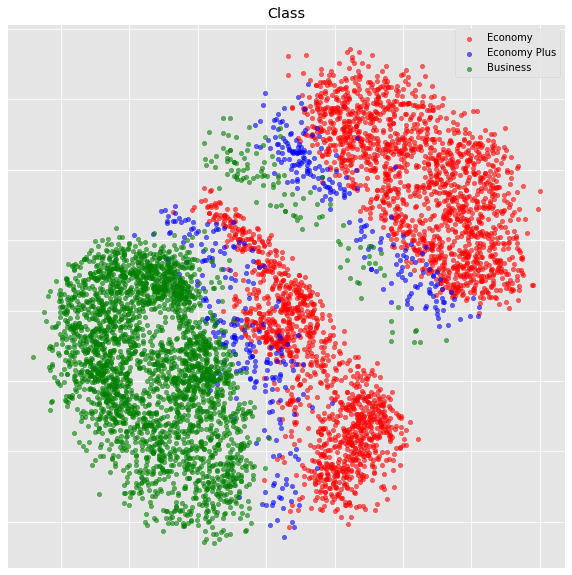

In [31]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=eco,node_size=20,node_color='r', alpha=0.6,label='Economy')
nx.draw_networkx_nodes(G,pos,nodelist=eco_plus,node_size=20,node_color='b', alpha=0.6,label='Economy Plus')
nx.draw_networkx_nodes(G,pos,nodelist=bus,node_size=20,node_color='g', alpha=0.6,label='Business')
plt.legend()
plt.title('Class')
plt.show()

In [32]:
personal = df.index[df['Type of Travel'] == 'Personal Travel'].tolist()
business = df.index[df['Type of Travel'] == 'Business travel'].tolist()

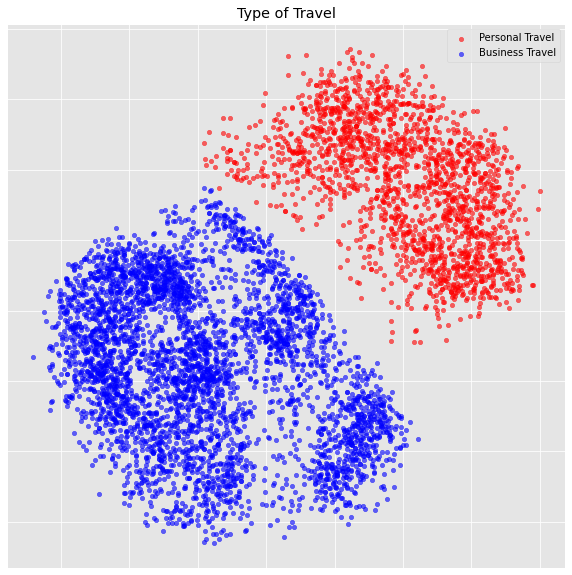

In [33]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=personal,node_size=20,node_color='r', alpha=0.6,label='Personal Travel')
nx.draw_networkx_nodes(G,pos,nodelist=business,node_size=20,node_color='b', alpha=0.6,label = 'Business Travel')
plt.legend()
plt.title('Type of Travel')
plt.show()

In [34]:
AGE = df.Age.apply(lambda x: 0 if x < 26 else(1 if x < 39 else(2 if x < 50 else 3)))

In [35]:
age0 = AGE.index[AGE == 0].tolist()
age1 = AGE.index[AGE == 1].tolist()
age2 = AGE.index[AGE == 2].tolist()
age3 = AGE.index[AGE == 3].tolist()

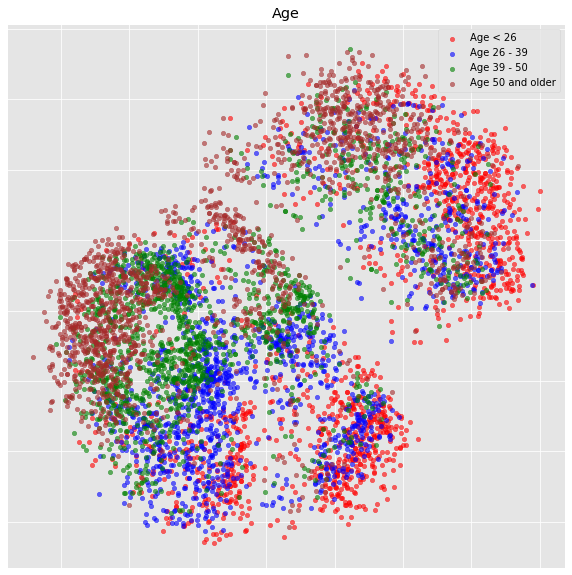

In [36]:
plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G,pos,nodelist=age0,node_size=20,node_color='r', alpha=0.6,label = 'Age < 26')
nx.draw_networkx_nodes(G,pos,nodelist=age1,node_size=20,node_color='b', alpha=0.6,label = 'Age 26 - 39')
nx.draw_networkx_nodes(G,pos,nodelist=age2,node_size=20,node_color='g', alpha=0.6,label = 'Age 39 - 50')
nx.draw_networkx_nodes(G,pos,nodelist=age3,node_size=20,node_color='brown', alpha=0.6,label = 'Age 50 and older' )
plt.legend()
plt.title('Age')
plt.show()

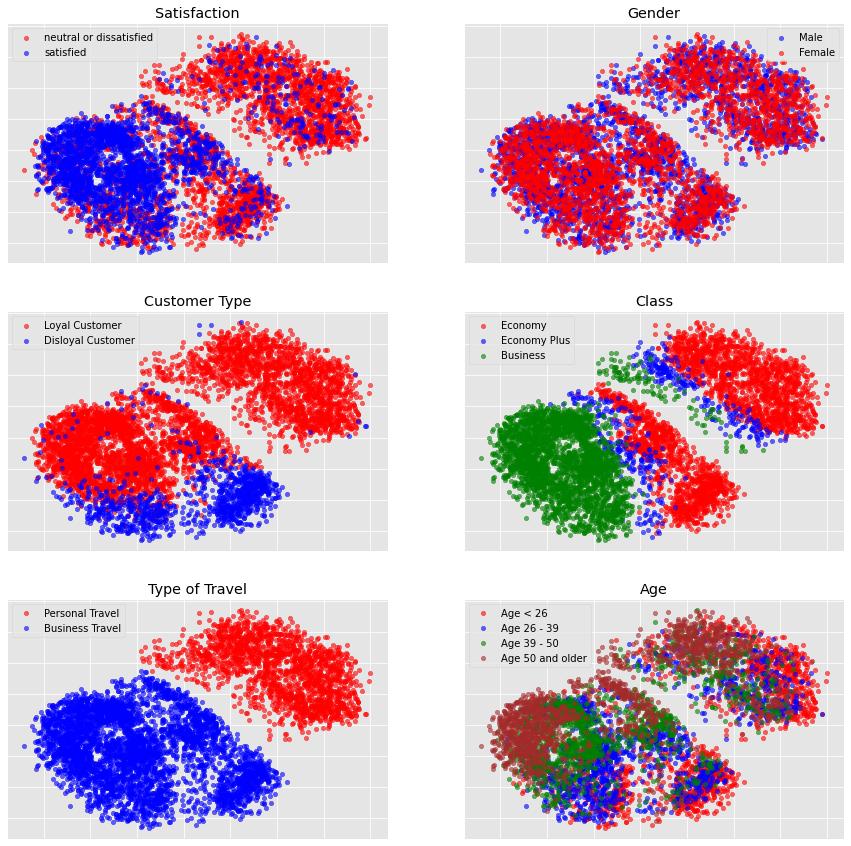

In [37]:
fig = plt.subplots(figsize=(15,15))

plt.subplot(321)
nx.draw_networkx_nodes(G,pos,nodelist=dissatisfied,node_size=20,node_color='r', alpha=0.6,label='neutral or dissatisfied')
nx.draw_networkx_nodes(G,pos,nodelist=satisfied,node_size=20,node_color='b', alpha=0.6,label='satisfied')
plt.title('Satisfaction')
plt.legend()

plt.subplot(322)
nx.draw_networkx_nodes(G,pos,nodelist=male,node_size=20,node_color='b', alpha=0.6,label='Male')
nx.draw_networkx_nodes(G,pos,nodelist=female,node_size=20,node_color='r', alpha=0.6,label='Female')
plt.title('Gender')
plt.legend()

plt.subplot(323)
nx.draw_networkx_nodes(G,pos,nodelist=loyal,node_size=20,node_color='r', alpha=0.6,label='Loyal Customer')
nx.draw_networkx_nodes(G,pos,nodelist=disloyal,node_size=20,node_color='b', alpha=0.6,label='Disloyal Customer')
plt.title('Customer Type')
plt.legend()

plt.subplot(324)
nx.draw_networkx_nodes(G,pos,nodelist=eco,node_size=20,node_color='r', alpha=0.6,label='Economy')
nx.draw_networkx_nodes(G,pos,nodelist=eco_plus,node_size=20,node_color='b', alpha=0.6,label='Economy Plus')
nx.draw_networkx_nodes(G,pos,nodelist=bus,node_size=20,node_color='g', alpha=0.6,label='Business')
plt.title('Class')
plt.legend()

plt.subplot(325)
nx.draw_networkx_nodes(G,pos,nodelist=personal,node_size=20,node_color='r', alpha=0.6,label='Personal Travel')
nx.draw_networkx_nodes(G,pos,nodelist=business,node_size=20,node_color='b', alpha=0.6,label = 'Business Travel')
plt.title('Type of Travel')
plt.legend()

plt.subplot(326)
nx.draw_networkx_nodes(G,pos,nodelist=age0,node_size=20,node_color='r', alpha=0.6,label = 'Age < 26')
nx.draw_networkx_nodes(G,pos,nodelist=age1,node_size=20,node_color='b', alpha=0.6,label = 'Age 26 - 39')
nx.draw_networkx_nodes(G,pos,nodelist=age2,node_size=20,node_color='g', alpha=0.6,label = 'Age 39 - 50')
nx.draw_networkx_nodes(G,pos,nodelist=age3,node_size=20,node_color='brown', alpha=0.6,label = 'Age 50 and older')
plt.title('Age')
plt.legend()

plt.show()


## Assign the Graph Data to a dgl Graph and Prepare the Data for Machine Learning

In [38]:
G_dgl = dgl.from_networkx(G)

G_dgl.ndata['feat'] =  torch.tensor(x_wd.values,dtype=torch.float)
G_dgl.ndata['train_mask'] = torch.zeros(len(G_dgl.nodes()), dtype=torch.bool).bernoulli(0.8)
G_dgl.ndata['label'] = torch.tensor(features)

In [39]:
G_dgl.ndata['val_mask'] = torch.empty(len(G_dgl.nodes()))
for i in range(len(G_dgl.ndata['train_mask'])):
    if G_dgl.ndata['train_mask'][i] == True:
        G_dgl.ndata['val_mask'][i] = False
    else:
        G_dgl.ndata['val_mask'][i] = True

G_dgl.ndata['val_mask'] = G_dgl.ndata['val_mask'].type(torch.bool)

In [40]:
node_features = G_dgl.ndata['feat']
node_labels = G_dgl.ndata['label']
train_mask = G_dgl.ndata['train_mask']
valid_mask = G_dgl.ndata['val_mask']
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)

In [41]:
train_nodes = (train_mask == True).nonzero(as_tuple=False)
train_nids = torch.reshape(train_nodes,(-1,))
valid_nodes = (valid_mask == True).nonzero(as_tuple=False)
valid_nids = torch.reshape(valid_nodes,(-1,))

In [42]:
len(train_nids)

4862

In [43]:
len(valid_nids)

1138

## Define the Dataloaders

In [44]:
batch_size = 50
sampler = dgl.dataloading.MultiLayerNeighborSampler([5,10])
train_dataloader = dgl.dataloading.NodeDataLoader(
    G_dgl, train_nids, sampler,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
    num_workers=0
)

In [45]:
example_minibatch = next(iter(train_dataloader))
print(example_minibatch)

[tensor([1965, 5001, 2561,  ..., 4547, 4185, 2366]), tensor([1965, 5001, 2561, 3911, 2992, 2103, 1467, 5508, 4951, 5224, 5051, 4696,
        4207, 5166, 5740, 1900, 5046, 2661, 5833, 4618, 4712, 1961, 3699, 5406,
        3778, 4039, 1073, 2203, 1814, 2818, 3851, 1484,  630, 2949,  460,  306,
        5237,  778, 3024, 4122, 2901, 5074, 5090,  621, 1217, 2040, 1074, 2477,
        2279, 4515]), [Block(num_src_nodes=2477, num_dst_nodes=530, num_edges=2650), Block(num_src_nodes=530, num_dst_nodes=50, num_edges=500)]]


In [46]:
input_nodes, output_nodes, bipartites = example_minibatch
print("To compute {} nodes' output we need {} nodes' input features".format(len(output_nodes), len(input_nodes)))

To compute 50 nodes' output we need 2477 nodes' input features


In [47]:
print(bipartites)

[Block(num_src_nodes=2477, num_dst_nodes=530, num_edges=2650), Block(num_src_nodes=530, num_dst_nodes=50, num_edges=500)]


In [48]:
batch_size = len(valid_nids)
valid_dataloader = dgl.dataloading.NodeDataLoader(
    G_dgl, valid_nids, sampler,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=0
)

## Define the GraphSage Model, Train and get Results

The aggregation types are named as follows:

- 'pool' = max-pooling
- 'mean' = mean aggregations
- 'lstm' = LSTM aggregation

For sum-pooling, the class SumSage is used where 'pool' refers to sum-pooling and makes used of the script in the file sage.py

Note, that the logSoftmax function is not defined in the Sage classes below for the final output layer. This is because, the logSoftmax function is automatically applied when calculating the loss using the F.cross_entropy function. For that reason, the logSoftmax function is applied separately in the training script for getting the predicted values. This is both true for the GraphSage and GCN models.

In [49]:
class SAGE(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers,agg_type='pool'):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        self.layers.append(dglnn.SAGEConv(in_feats, n_hidden, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        for i in range(1, n_layers - 1):
            self.layers.append(dglnn.SAGEConv(n_hidden, n_hidden, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        self.layers.append(dglnn.SAGEConv(n_hidden, n_classes, aggregator_type=agg_type, bias=True, feat_drop=0.02,norm=None,activation=None))
        
    def forward(self, bipartites, x):
        for l, (layer, bipartite) in enumerate(zip(self.layers, bipartites)):
            x = layer(bipartite, x)
        return x

In [50]:
## Used for sum-pooling
class SumSAGE(nn.Module):
    def __init__(self, in_feats, n_hidden, n_classes, n_layers):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        self.layers.append(SAGEConv(in_feats, n_hidden, aggregator_type='pool', bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        for i in range(1, n_layers - 1):
            self.layers.append(SAGEConv(n_hidden, n_hidden, aggregator_type='pool', bias=True, feat_drop=0.02,norm=Norm,activation=nn.ReLU(inplace=False)))
        self.layers.append(SAGEConv(n_hidden, n_classes, aggregator_type='pool', bias=True, feat_drop=0.02,norm=None,activation=None))
        
    def forward(self, bipartites, x):
        for l, (layer, bipartite) in enumerate(zip(self.layers, bipartites)):
            x = layer(bipartite, x)
            
        return x

In [51]:
# choose between sumSage or the standard GraphSage models and define the optimizer

#model = SumSAGE(n_features, len(x_wd.T), n_labels, 2) #n_layers
model = SAGE(n_features, len(x_wd.T), n_labels, 2, agg_type='pool') #n_layers
opt = torch.optim.Adam(model.parameters(),lr=0.002)#deine optimizer

Below the GraphSage model is trained

In [52]:
# GraphSage
best_accuracy = 0
best_model_path = 'model.pt'
epoch_losses_train = []
plot_loss_valid = []
train_acc = []
valid_acc = []
dur = []

for epoch in range(400):
    t0 = time.time()
    model.train()
    loss_epoch = 0
    accuracy_epoch = 0
    for step, (input_nodes, output_nodes, bipartites) in enumerate(train_dataloader):
        inputs = node_features[input_nodes]
        labels = node_labels[output_nodes]
        logits = model(bipartites, inputs)
        predictions = F.log_softmax(logits,dim=1)

        loss = F.cross_entropy(logits, labels)
        loss_epoch += loss.detach().item()
        opt.zero_grad()
        loss.backward()
        opt.step()

        accuracy = accuracy_score(labels.numpy(), predictions.argmax(1).detach().numpy())
        accuracy_epoch += accuracy
    accuracy_epoch /= (step + 1)
    loss_epoch /= (step + 1)
    epoch_losses_train.append(loss_epoch)
    train_acc.append(accuracy_epoch)
    print('Epoch: {}, Training Accuracy: {:.3f}, Training Loss: {:.3f}'.format(epoch, accuracy_epoch, loss_epoch))
        
    model.eval()
    
    predictions = []
    labels = []
    with torch.no_grad():
        for input_nodes, output_nodes, bipartites in valid_dataloader:
            inputs = node_features[input_nodes]
            labels.append(node_labels[output_nodes].numpy())
            predictions.append(F.log_softmax(model(bipartites, inputs),dim=1).argmax(1).numpy())
            valid_logits = model(bipartites, inputs)
            valid_labels = node_labels[output_nodes]
            valid_loss = F.cross_entropy(valid_logits, valid_labels)

        predictions = np.concatenate(predictions)
        labels = np.concatenate(labels)
        
        accuracy = accuracy_score(labels, predictions)
        dur.append(time.time() - t0)
        print('Epoch: {}, Validation Accuracy: {:.3f}, Validation Loss: {:.3f}, Time: {:.4f}'.format(epoch, accuracy, valid_loss.item(), np.mean(dur)))
        valid_acc.append(accuracy.item())
        plot_loss_valid.append(valid_loss.item())
    
torch.save(model.state_dict(), best_model_path)


Epoch: 0, Training Accuracy: 0.642, Training Loss: 0.633
Epoch: 0, Validation Accuracy: 0.774, Validation Loss: 0.528, Time: 2.0162
Epoch: 1, Training Accuracy: 0.814, Training Loss: 0.455
Epoch: 1, Validation Accuracy: 0.840, Validation Loss: 0.404, Time: 1.6429
Epoch: 2, Training Accuracy: 0.843, Training Loss: 0.397
Epoch: 2, Validation Accuracy: 0.847, Validation Loss: 0.370, Time: 1.5652
Epoch: 3, Training Accuracy: 0.852, Training Loss: 0.376
Epoch: 3, Validation Accuracy: 0.860, Validation Loss: 0.352, Time: 1.5226
Epoch: 4, Training Accuracy: 0.848, Training Loss: 0.368
Epoch: 4, Validation Accuracy: 0.864, Validation Loss: 0.339, Time: 1.5087
Epoch: 5, Training Accuracy: 0.862, Training Loss: 0.346
Epoch: 5, Validation Accuracy: 0.866, Validation Loss: 0.340, Time: 1.5020
Epoch: 6, Training Accuracy: 0.869, Training Loss: 0.337
Epoch: 6, Validation Accuracy: 0.867, Validation Loss: 0.328, Time: 1.5189
Epoch: 7, Training Accuracy: 0.863, Training Loss: 0.336
Epoch: 7, Validatio

Epoch: 62, Training Accuracy: 0.940, Training Loss: 0.155
Epoch: 62, Validation Accuracy: 0.933, Validation Loss: 0.166, Time: 1.3457
Epoch: 63, Training Accuracy: 0.939, Training Loss: 0.157
Epoch: 63, Validation Accuracy: 0.936, Validation Loss: 0.173, Time: 1.3429
Epoch: 64, Training Accuracy: 0.935, Training Loss: 0.165
Epoch: 64, Validation Accuracy: 0.924, Validation Loss: 0.186, Time: 1.3405
Epoch: 65, Training Accuracy: 0.938, Training Loss: 0.156
Epoch: 65, Validation Accuracy: 0.935, Validation Loss: 0.165, Time: 1.3396
Epoch: 66, Training Accuracy: 0.934, Training Loss: 0.161
Epoch: 66, Validation Accuracy: 0.936, Validation Loss: 0.162, Time: 1.3399
Epoch: 67, Training Accuracy: 0.936, Training Loss: 0.160
Epoch: 67, Validation Accuracy: 0.939, Validation Loss: 0.159, Time: 1.3372
Epoch: 68, Training Accuracy: 0.939, Training Loss: 0.157
Epoch: 68, Validation Accuracy: 0.941, Validation Loss: 0.155, Time: 1.3356
Epoch: 69, Training Accuracy: 0.941, Training Loss: 0.153
Epoc

Epoch: 123, Training Accuracy: 0.946, Training Loss: 0.142
Epoch: 123, Validation Accuracy: 0.939, Validation Loss: 0.145, Time: 1.3047
Epoch: 124, Training Accuracy: 0.942, Training Loss: 0.140
Epoch: 124, Validation Accuracy: 0.946, Validation Loss: 0.150, Time: 1.3028
Epoch: 125, Training Accuracy: 0.945, Training Loss: 0.139
Epoch: 125, Validation Accuracy: 0.938, Validation Loss: 0.146, Time: 1.3010
Epoch: 126, Training Accuracy: 0.944, Training Loss: 0.133
Epoch: 126, Validation Accuracy: 0.942, Validation Loss: 0.151, Time: 1.2992
Epoch: 127, Training Accuracy: 0.949, Training Loss: 0.138
Epoch: 127, Validation Accuracy: 0.941, Validation Loss: 0.143, Time: 1.2975
Epoch: 128, Training Accuracy: 0.946, Training Loss: 0.140
Epoch: 128, Validation Accuracy: 0.941, Validation Loss: 0.144, Time: 1.2965
Epoch: 129, Training Accuracy: 0.945, Training Loss: 0.140
Epoch: 129, Validation Accuracy: 0.940, Validation Loss: 0.154, Time: 1.2956
Epoch: 130, Training Accuracy: 0.942, Training L

Epoch: 184, Training Accuracy: 0.949, Training Loss: 0.131
Epoch: 184, Validation Accuracy: 0.946, Validation Loss: 0.136, Time: 1.3083
Epoch: 185, Training Accuracy: 0.947, Training Loss: 0.134
Epoch: 185, Validation Accuracy: 0.942, Validation Loss: 0.137, Time: 1.3096
Epoch: 186, Training Accuracy: 0.950, Training Loss: 0.128
Epoch: 186, Validation Accuracy: 0.941, Validation Loss: 0.139, Time: 1.3123
Epoch: 187, Training Accuracy: 0.948, Training Loss: 0.133
Epoch: 187, Validation Accuracy: 0.943, Validation Loss: 0.153, Time: 1.3158
Epoch: 188, Training Accuracy: 0.946, Training Loss: 0.134
Epoch: 188, Validation Accuracy: 0.942, Validation Loss: 0.142, Time: 1.3179
Epoch: 189, Training Accuracy: 0.950, Training Loss: 0.129
Epoch: 189, Validation Accuracy: 0.944, Validation Loss: 0.135, Time: 1.3178
Epoch: 190, Training Accuracy: 0.950, Training Loss: 0.126
Epoch: 190, Validation Accuracy: 0.946, Validation Loss: 0.142, Time: 1.3167
Epoch: 191, Training Accuracy: 0.954, Training L

Epoch: 245, Training Accuracy: 0.951, Training Loss: 0.126
Epoch: 245, Validation Accuracy: 0.941, Validation Loss: 0.147, Time: 1.3251
Epoch: 246, Training Accuracy: 0.947, Training Loss: 0.130
Epoch: 246, Validation Accuracy: 0.938, Validation Loss: 0.155, Time: 1.3247
Epoch: 247, Training Accuracy: 0.954, Training Loss: 0.122
Epoch: 247, Validation Accuracy: 0.945, Validation Loss: 0.138, Time: 1.3268
Epoch: 248, Training Accuracy: 0.953, Training Loss: 0.121
Epoch: 248, Validation Accuracy: 0.940, Validation Loss: 0.163, Time: 1.3261
Epoch: 249, Training Accuracy: 0.950, Training Loss: 0.127
Epoch: 249, Validation Accuracy: 0.943, Validation Loss: 0.145, Time: 1.3256
Epoch: 250, Training Accuracy: 0.953, Training Loss: 0.121
Epoch: 250, Validation Accuracy: 0.946, Validation Loss: 0.139, Time: 1.3250
Epoch: 251, Training Accuracy: 0.953, Training Loss: 0.117
Epoch: 251, Validation Accuracy: 0.947, Validation Loss: 0.150, Time: 1.3252
Epoch: 252, Training Accuracy: 0.953, Training L

Epoch: 306, Training Accuracy: 0.949, Training Loss: 0.127
Epoch: 306, Validation Accuracy: 0.943, Validation Loss: 0.136, Time: 1.3090
Epoch: 307, Training Accuracy: 0.954, Training Loss: 0.118
Epoch: 307, Validation Accuracy: 0.948, Validation Loss: 0.139, Time: 1.3089
Epoch: 308, Training Accuracy: 0.953, Training Loss: 0.120
Epoch: 308, Validation Accuracy: 0.945, Validation Loss: 0.140, Time: 1.3086
Epoch: 309, Training Accuracy: 0.952, Training Loss: 0.120
Epoch: 309, Validation Accuracy: 0.946, Validation Loss: 0.141, Time: 1.3082
Epoch: 310, Training Accuracy: 0.951, Training Loss: 0.124
Epoch: 310, Validation Accuracy: 0.941, Validation Loss: 0.137, Time: 1.3079
Epoch: 311, Training Accuracy: 0.953, Training Loss: 0.116
Epoch: 311, Validation Accuracy: 0.938, Validation Loss: 0.166, Time: 1.3077
Epoch: 312, Training Accuracy: 0.951, Training Loss: 0.124
Epoch: 312, Validation Accuracy: 0.942, Validation Loss: 0.149, Time: 1.3076
Epoch: 313, Training Accuracy: 0.953, Training L

Epoch: 367, Training Accuracy: 0.951, Training Loss: 0.122
Epoch: 367, Validation Accuracy: 0.946, Validation Loss: 0.138, Time: 1.2943
Epoch: 368, Training Accuracy: 0.954, Training Loss: 0.115
Epoch: 368, Validation Accuracy: 0.946, Validation Loss: 0.153, Time: 1.2941
Epoch: 369, Training Accuracy: 0.948, Training Loss: 0.128
Epoch: 369, Validation Accuracy: 0.949, Validation Loss: 0.128, Time: 1.2937
Epoch: 370, Training Accuracy: 0.952, Training Loss: 0.125
Epoch: 370, Validation Accuracy: 0.946, Validation Loss: 0.154, Time: 1.2934
Epoch: 371, Training Accuracy: 0.953, Training Loss: 0.118
Epoch: 371, Validation Accuracy: 0.943, Validation Loss: 0.138, Time: 1.2933
Epoch: 372, Training Accuracy: 0.956, Training Loss: 0.112
Epoch: 372, Validation Accuracy: 0.947, Validation Loss: 0.135, Time: 1.2931
Epoch: 373, Training Accuracy: 0.956, Training Loss: 0.114
Epoch: 373, Validation Accuracy: 0.950, Validation Loss: 0.144, Time: 1.2931
Epoch: 374, Training Accuracy: 0.953, Training L

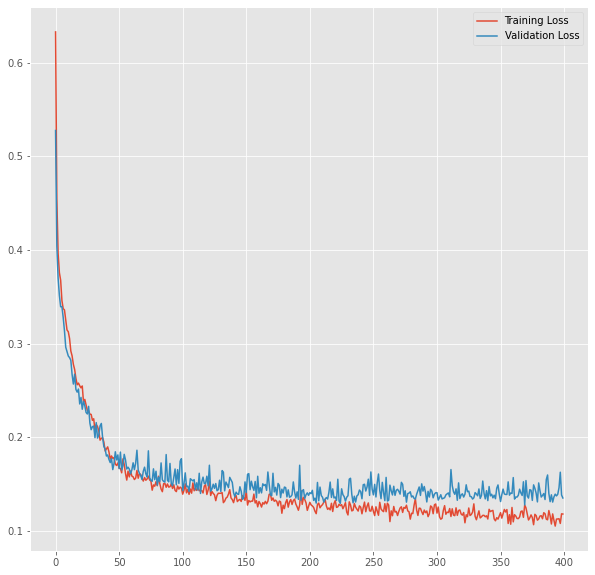

In [53]:
plt.figure(figsize=(10,10))
plt.plot(epoch_losses_train, label='Training Loss')
plt.plot(plot_loss_valid, label='Validation Loss')
plt.legend()
plt.show()

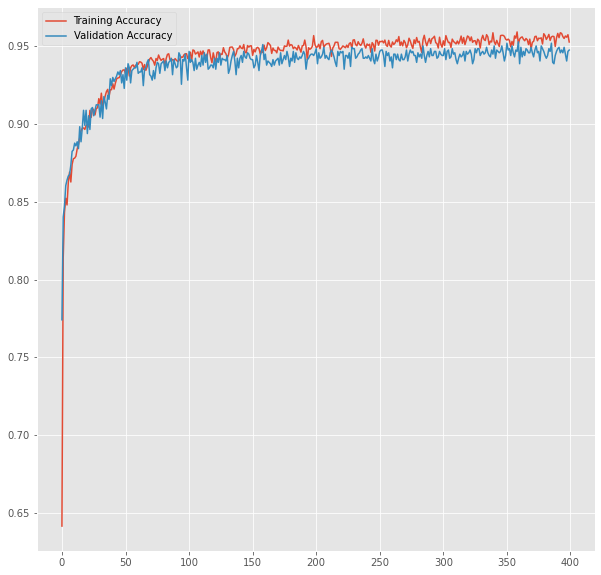

In [54]:
plt.figure(figsize=(10,10))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(valid_acc, label='Validation Accuracy')
plt.legend()
plt.show()

In [55]:
print('Training Accuracy: {}'.format(train_acc[-1]))
print('Validation Accuracy: {}'.format(valid_acc[-1]))

Training Accuracy: 0.9524489795918362
Validation Accuracy: 0.9472759226713533


In [56]:
np.argmax(valid_acc)

359

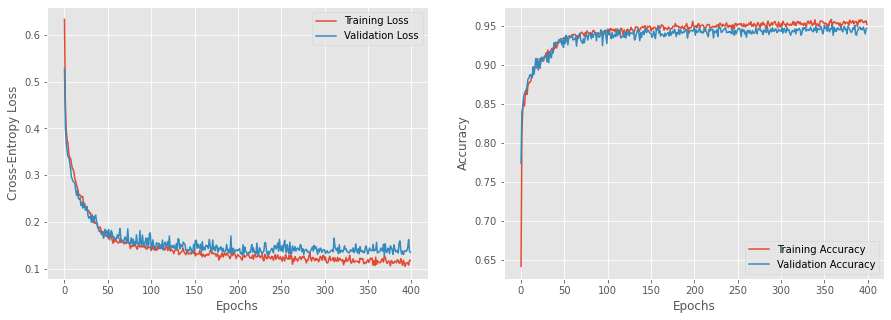

In [57]:
plt.subplots(figsize=(15,5))

plt.subplot(121)
plt.plot(epoch_losses_train, label='Training Loss')
plt.plot(plot_loss_valid, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

plt.subplot(122)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(valid_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [58]:
# shows the model parameters of the GraphSage model
model.parameters

<bound method Module.parameters of SAGE(
  (layers): ModuleList(
    (0): SAGEConv(
      (feat_drop): Dropout(p=0.02, inplace=False)
      (activation): ReLU()
      (fc_pool): Linear(in_features=24, out_features=24, bias=True)
      (fc_self): Linear(in_features=24, out_features=24, bias=False)
      (fc_neigh): Linear(in_features=24, out_features=24, bias=False)
    )
    (1): SAGEConv(
      (feat_drop): Dropout(p=0.02, inplace=False)
      (fc_pool): Linear(in_features=24, out_features=24, bias=True)
      (fc_self): Linear(in_features=24, out_features=2, bias=False)
      (fc_neigh): Linear(in_features=24, out_features=2, bias=False)
    )
  )
)>

## Graph Convolutional Network

Below the dgl data is reset to 30% training and 70 validation data which is then used for the GCN.

In [59]:
G_dgl.ndata['feat'] =  torch.tensor(x_wd.values,dtype=torch.float)
G_dgl.ndata['train_mask'] = torch.zeros(len(G_dgl.nodes()), dtype=torch.bool).bernoulli(0.3)
G_dgl.ndata['label'] = torch.tensor(features)

G_dgl.ndata['val_mask'] = torch.empty(len(G_dgl.nodes()))
for i in range(len(G_dgl.ndata['train_mask'])):
    if G_dgl.ndata['train_mask'][i] == True:
        G_dgl.ndata['val_mask'][i] = False
    else:
        G_dgl.ndata['val_mask'][i] = True

G_dgl.ndata['val_mask'] = G_dgl.ndata['val_mask'].type(torch.bool)

node_features = G_dgl.ndata['feat']
node_labels = G_dgl.ndata['label']
train_mask = G_dgl.ndata['train_mask']
valid_mask = G_dgl.ndata['val_mask']
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)

Define the GCN network

In [60]:
class GCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.conv1 = dglnn.pytorch.conv.GraphConv(
            in_feats=in_feats, out_feats=hid_feats,norm='both', weight=True, bias=True, activation=nn.ReLU(inplace=False))
        
        self.conv2 = dglnn.pytorch.conv.GraphConv(
            in_feats=hid_feats, out_feats=out_feats,norm='both', weight=True, bias=True, activation=None)
        
    def forward(self, graph, inputs):
        h = self.conv1(graph, inputs)
        h = self.conv2(graph, h)
        return h

Compile the model

In [61]:
model_gcn = GCN(n_features, len(x_wd.T) , n_labels) # 
opt = torch.optim.Adam(model_gcn.parameters(),lr=0.002)#GCN

In [62]:
def evaluate(model_gcn, graph, features, labels, mask):
    model_gcn.eval()
    with torch.no_grad():
        logits = model_gcn(graph, features)
        logits = logits[mask]
        labels = labels[mask]
        preds = F.log_softmax(logits,dim=1)
        _, indices = torch.max(preds, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

Train the model

In [63]:
#model = GCN(in_feats=n_features, hid_feats_1=128, hid_feats_2=128, out_feats=n_labels)
#opt = torch.optim.Adam(model.parameters(),lr=1e-2)
plot_loss_train = []
plot_loss_val = []
valid_acc = []
train_acc = []
dur = []
for epoch in range(1000):
    t0 = time.time()
    model_gcn.train()
    # forward propagation by using all nodes
    logits = model_gcn(G_dgl, node_features)
    # compute loss
    loss_train = F.cross_entropy(logits[train_mask], node_labels[train_mask])
    acc_train = evaluate(model_gcn, G_dgl, node_features, node_labels, train_mask)
    train_acc.append(acc_train)
    plot_loss_train.append(loss_train.item())
    opt.zero_grad()
    loss_train.backward()
    opt.step()
    
    model_gcn.eval()
    
    # compute validation accuracy
    with torch.no_grad():
        acc_val = evaluate(model_gcn, G_dgl, node_features, node_labels, valid_mask)
        loss_val = F.cross_entropy(logits[valid_mask], node_labels[valid_mask])
        valid_acc.append(acc_val)
        plot_loss_val.append(loss_val.item())
    # backward propagation
    
    dur.append(time.time() - t0)
    if epoch % 10 == 0:
        print('Epoch: {}, train loss: {:.4f}, validation loss: {:.4f}, training accuracy: {:.4f}, validation accuracy: {:.4f}, Time: {:.4f}'.format(epoch,loss_train.item(),loss_val.item(),acc_train,acc_val,np.mean(dur)))


Epoch: 0, train loss: 0.7032, validation loss: 0.7025, training accuracy: 0.5037, validation accuracy: 0.5713, Time: 0.5093
Epoch: 10, train loss: 0.6819, validation loss: 0.6811, training accuracy: 0.5686, validation accuracy: 0.5713, Time: 0.6962
Epoch: 20, train loss: 0.6634, validation loss: 0.6633, training accuracy: 0.5686, validation accuracy: 0.5713, Time: 0.5963
Epoch: 30, train loss: 0.6454, validation loss: 0.6459, training accuracy: 0.5686, validation accuracy: 0.6990, Time: 0.5549
Epoch: 40, train loss: 0.6281, validation loss: 0.6293, training accuracy: 0.7696, validation accuracy: 0.7600, Time: 0.4985
Epoch: 50, train loss: 0.6117, validation loss: 0.6135, training accuracy: 0.7589, validation accuracy: 0.7616, Time: 0.4628
Epoch: 60, train loss: 0.5961, validation loss: 0.5981, training accuracy: 0.7651, validation accuracy: 0.7628, Time: 0.4339
Epoch: 70, train loss: 0.5819, validation loss: 0.5843, training accuracy: 0.7640, validation accuracy: 0.7595, Time: 0.4118
E

Epoch: 660, train loss: 0.4872, validation loss: 0.4947, training accuracy: 0.7685, validation accuracy: 0.7621, Time: 0.3679
Epoch: 670, train loss: 0.4871, validation loss: 0.4945, training accuracy: 0.7696, validation accuracy: 0.7619, Time: 0.3687
Epoch: 680, train loss: 0.4873, validation loss: 0.4940, training accuracy: 0.7685, validation accuracy: 0.7619, Time: 0.3688
Epoch: 690, train loss: 0.4870, validation loss: 0.4953, training accuracy: 0.7696, validation accuracy: 0.7633, Time: 0.3678
Epoch: 700, train loss: 0.4867, validation loss: 0.4943, training accuracy: 0.7696, validation accuracy: 0.7621, Time: 0.3677
Epoch: 710, train loss: 0.4866, validation loss: 0.4943, training accuracy: 0.7696, validation accuracy: 0.7619, Time: 0.3678
Epoch: 720, train loss: 0.4865, validation loss: 0.4944, training accuracy: 0.7691, validation accuracy: 0.7631, Time: 0.3676
Epoch: 730, train loss: 0.4865, validation loss: 0.4943, training accuracy: 0.7696, validation accuracy: 0.7631, Time:

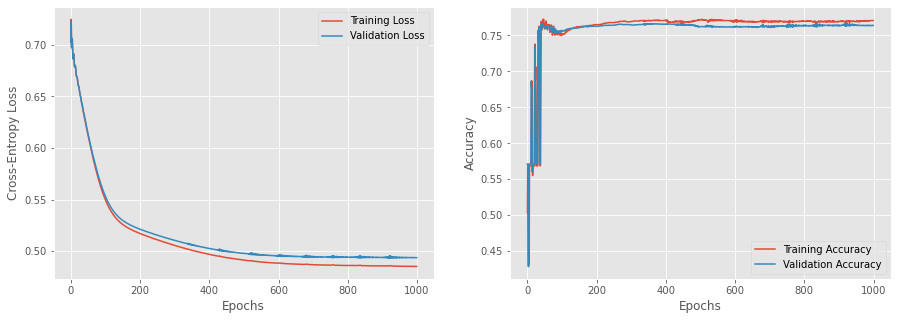

In [64]:
plt.subplots(figsize=(15,5))

plt.subplot(121)
plt.plot(plot_loss_train,label='Training Loss')
plt.plot(plot_loss_val,label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

plt.subplot(122)
plt.plot(train_acc,label='Training Accuracy')
plt.plot(valid_acc,label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [65]:
val_tens = torch.tensor(features)
_, indices_val = torch.max(logits[valid_mask], dim=1)
val_lab = val_tens[valid_mask]
train_lab = val_tens[train_mask]
_, indices_train = torch.max(logits[train_mask], dim=1)

print('Classification Accuracy validation set {}'.format(accuracy_score(val_lab,indices_val)))
print('-------------------------------------------------------------')
print('Classification Accuracy training set {}'.format(accuracy_score(train_lab,indices_train)))
print('-------------------------------------------------------------')
print('Confusion Matrix validation set:')
print(confusion_matrix(val_lab, indices_val))
print('-------------------------------------------------------------')
print('Confusion Matrix training set:')
print(confusion_matrix(train_lab,indices_train))


Classification Accuracy validation set 0.76377394183022
-------------------------------------------------------------
Classification Accuracy training set 0.7707509881422925
-------------------------------------------------------------
Confusion Matrix validation set:
[[1853  563]
 [ 436 1377]]
-------------------------------------------------------------
Confusion Matrix training set:
[[787 220]
 [186 578]]


In [66]:
model_gcn.parameters

<bound method Module.parameters of GCN(
  (conv1): GraphConv(
    in=24, out=24, normalization=both
    (_activation): ReLU()
  )
  (conv2): GraphConv(in=24, out=2, normalization=both, activation=None)
)>

## Generate Test Graph

Based on the test data, a new test graph is generated. This is the same procedure as is done in the the data script. It is repeated here for the test graph so that every A-Z simulation contains a new test graph. This ensures, that there is not some graph sampling bias. Note, different training graphs were tested as well. The results are consistent regardless of the generated graph.

In [67]:
# gender
gend_alpha0 = 0.60
gend_beta1 = 0.40

aff_gend = np.array([[gend_alpha0,gend_beta1],
                     [gend_beta1,gend_alpha0]])

# customer type (loyal vs disoyal)

type_alpha0 = 0.8
type_beta1 = 0.5

aff_type = np.array([[type_alpha0, type_beta1],
                     [type_beta1, type_alpha0]])


# age
age_alpha0 = 0.90
age_beta1 = 0.80
age_beta2 = 0.60
age_beta3 = 0.40

aff_age = np.array([[age_alpha0,age_beta1,age_beta2,age_beta3],
                    [age_beta1,age_alpha0,age_beta1,age_beta2],
                    [age_beta2,age_beta1,age_alpha0,age_beta1],
                    [age_beta3,age_beta2,age_beta1,age_alpha0]])


# Type of travel
trav_type_alpha0 = 0.80
trav_type_beta1 = 0.20

aff_trav_type = np.array([[trav_type_alpha0, trav_type_beta1],
                          [trav_type_beta1, trav_type_alpha0]])

# Class

class_alpha0 = 0.85
class_beta1 = 0.60
class_beta2 = 0.40

aff_class = np.array([[class_alpha0, class_beta1, class_beta2],
                      [class_beta1, class_alpha0, class_beta1],
                      [class_beta2, class_beta1, class_alpha0]])


aff = {0:aff_gend, 1:aff_type, 2:aff_age, 3:aff_trav_type, 4:aff_class}

In [68]:
x = test_gen.to_numpy()
x = x.astype(int)
x = x.T

P_u_v = np.empty((len(x.T),len(x.T)))
prob_u_v = np.empty((len(x),1))
u = np.empty((len(x),1))
v = np.empty((len(x),1))

# create probability for connection between u and v
for i in range(len(x.T)):
    u = x[:,i]

    for k in range(len(x.T)):
        v = x[:,k]

        for j in range(len(x)):
            aff_current = aff[j]
            prob_u_v[j] = aff_current[u[j],v[j]]

        P_u_v[i,k] = np.prod(prob_u_v)

In [69]:
A = np.triu(P_u_v,1)

for i in range(len(P_u_v)):
    for j in range(len(P_u_v)):
        if A[i,j] > np.random.rand():
            A[i,j] = 1
        else:
            A[i,j] = 0

In [70]:
A = A + A.T

In [71]:
G_test = nx.from_numpy_matrix(A)

In [72]:
test_features = pd.Series(TEST.satisfaction)

## Assign the data to a dgl graph

In [73]:
G_dgl_test = dgl.from_networkx(G_test)
feat_test = TEST.drop(columns=['satisfaction'])
feat_test = pd.get_dummies(data=feat_test,columns=['Customer Type','Type of Travel','Gender'])
feat_test[['Age','Departure Delay in Minutes','Flight Distance']] = normalize(feat_test[['Age','Departure Delay in Minutes','Flight Distance']])

G_dgl_test.ndata['feat'] =  torch.tensor(feat_test.values,dtype=torch.float)
G_dgl_test.ndata['label'] = torch.tensor(test_features)

In [74]:
node_features = G_dgl_test.ndata['feat']
node_labels = G_dgl_test.ndata['label']
test_nids = G_dgl_test.nodes()
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)

## Define the inference function to get the test graph results

In [75]:
def inference(model, graph, input_features, batch_size):
    nodes = torch.arange(graph.number_of_nodes())
    
    sampler = dgl.dataloading.MultiLayerNeighborSampler([5,10]) 
    dataloader = dgl.dataloading.NodeDataLoader(
        graph, nodes, sampler,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=0)
    
    with torch.no_grad():
        for l, layer in enumerate(model.layers):
            output_features = torch.zeros(
                graph.number_of_nodes(), model.n_hidden if l != model.n_layers - 1 else model.n_classes)

            for input_nodes, output_nodes, bipartites in tqdm.tqdm(dataloader):
                bipartite = bipartites[0]
                x = input_features[input_nodes]
                x = layer(bipartite, x)
                output_features[output_nodes] = x
            input_features = output_features
    return output_features

## Get the test graph results

In [76]:
model.load_state_dict(torch.load('model.pt'))
all_logits = inference(model, G_dgl_test, node_features, 6000)

100%|██████████| 1/1 [00:00<00:00, 12.32it/s]


In [77]:
test_predictions = F.log_softmax(all_logits[test_nids],dim=1).argmax(1)
test_labels = node_labels[test_nids]
test_accuracy = sklearn.metrics.accuracy_score(test_predictions.numpy(), test_labels.numpy())
print('Test accuracy:', test_accuracy)

Test accuracy: 0.9445


In [78]:
print('Classification Accuracy test set {}'.format(accuracy_score(test_labels.numpy(),test_predictions.numpy())))
print('-------------------------------------------------------------')
print('Confusion Matrix test set:')
print(confusion_matrix(test_labels.numpy(),test_predictions.numpy()))

Classification Accuracy test set 0.9445
-------------------------------------------------------------
Confusion Matrix test set:
[[3347   84]
 [ 249 2320]]


In [79]:
sklearn.metrics.f1_score(test_labels.numpy(),test_predictions.numpy(),average='micro')

0.9445

In [80]:
test_loss = F.cross_entropy(all_logits[test_nids],test_labels).numpy()
test_loss

array(0.14467257, dtype=float32)

In [81]:
model.layers

ModuleList(
  (0): SAGEConv(
    (feat_drop): Dropout(p=0.02, inplace=False)
    (activation): ReLU()
    (fc_pool): Linear(in_features=24, out_features=24, bias=True)
    (fc_self): Linear(in_features=24, out_features=24, bias=False)
    (fc_neigh): Linear(in_features=24, out_features=24, bias=False)
  )
  (1): SAGEConv(
    (feat_drop): Dropout(p=0.02, inplace=False)
    (fc_pool): Linear(in_features=24, out_features=24, bias=True)
    (fc_self): Linear(in_features=24, out_features=2, bias=False)
    (fc_neigh): Linear(in_features=24, out_features=2, bias=False)
  )
)

## ANN Simulations

The following code was used to simulated the consistency of ANN results. This was done to compare the ANN results with the GNN results.

In [82]:
f = pd.get_dummies(features)
yy_test = pd.get_dummies(yy)


model = Sequential()

model.add(Dense(15, activation='relu')) # len(x_wd.T)
model.add(Dropout(0.01))
model.add(Dense(2, activation='softmax'))
model.add(Dropout(0.01))
opt = tf.keras.optimizers.Adam(learning_rate=0.002) #5e-4

def sim_ann(model,opt,f,x_wd,xx_dummy,yy_test):
    train_loss = []
    val_loss = []
    test_loss = []
    train_acc = []
    val_acc = []
    test_acc = []
    for i in range(10):
        x_train, x_test, y_train, y_test = train_test_split(x_wd,f, test_size = 0.2, shuffle=True)

        x_train_tf = tf.convert_to_tensor(x_train)
        x_test_tf = tf.convert_to_tensor(x_test)
        y_train_tf = tf.convert_to_tensor(y_train)
        y_test_tf = tf.convert_to_tensor(y_test)

        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        history = model.fit(x_train_tf, y_train_tf,validation_data=(x_test_tf,y_test_tf), epochs=400, batch_size=50)
        
        train_loss.append(history.history['loss'][-1])
        val_loss.append(history.history['val_loss'][-1])
        train_acc.append(history.history['accuracy'][-1])
        val_acc.append(history.history['val_accuracy'][-1])
        
        results = model.evaluate(xx_dummy, yy_test, batch_size=128)
        test_loss.append(results[0])
        test_acc.append(results[1])
        print("test loss, test acc:", results)
    
    return train_loss, val_loss, test_loss, train_acc, val_acc, test_acc
        
train_loss, val_loss, test_loss, train_acc, val_acc, test_acc = sim_ann(model,opt,f,x_wd,xx_dummy,yy_test)
        
    

Epoch 1/400
96/96 [==============================] - 3s 18ms/step - loss: 1.9436 - accuracy: 0.5012 - val_loss: 0.6009 - val_accuracy: 0.6783
Epoch 2/400
96/96 [==============================] - 0s 2ms/step - loss: 0.6788 - accuracy: 0.6834 - val_loss: 0.4807 - val_accuracy: 0.7892
Epoch 3/400
96/96 [==============================] - 0s 3ms/step - loss: 0.5572 - accuracy: 0.7863 - val_loss: 0.4352 - val_accuracy: 0.8133
Epoch 4/400
96/96 [==============================] - 0s 2ms/step - loss: 0.4931 - accuracy: 0.8053 - val_loss: 0.3731 - val_accuracy: 0.8475
Epoch 5/400
96/96 [==============================] - 0s 2ms/step - loss: 0.4687 - accuracy: 0.8302 - val_loss: 0.3355 - val_accuracy: 0.8592
Epoch 6/400
96/96 [==============================] - 0s 2ms/step - loss: 0.3819 - accuracy: 0.8617 - val_loss: 0.3032 - val_accuracy: 0.8783
Epoch 7/400
96/96 [==============================] - 0s 2ms/step - loss: 0.4120 - accuracy: 0.8600 - val_loss: 0.2799 - val_accuracy: 0.8917
Epoch 8/400


Epoch 59/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2219 - accuracy: 0.9354 - val_loss: 0.1536 - val_accuracy: 0.9358
Epoch 60/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2114 - accuracy: 0.9393 - val_loss: 0.1518 - val_accuracy: 0.9383
Epoch 61/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2248 - accuracy: 0.9383 - val_loss: 0.1742 - val_accuracy: 0.9283
Epoch 62/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2464 - accuracy: 0.9284 - val_loss: 0.1581 - val_accuracy: 0.9367
Epoch 63/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2186 - accuracy: 0.9323 - val_loss: 0.1595 - val_accuracy: 0.9308
Epoch 64/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2611 - accuracy: 0.9242 - val_loss: 0.1527 - val_accuracy: 0.9367
Epoch 65/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2347 - accuracy: 0.9364 - val_loss: 0.1531 - val_accuracy: 0.9342
Epoch 

96/96 [==============================] - 0s 2ms/step - loss: 0.1814 - accuracy: 0.9421 - val_loss: 0.1423 - val_accuracy: 0.9375
Epoch 117/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1890 - accuracy: 0.9431 - val_loss: 0.1424 - val_accuracy: 0.9408
Epoch 118/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2217 - accuracy: 0.9363 - val_loss: 0.1406 - val_accuracy: 0.9367
Epoch 119/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2092 - accuracy: 0.9357 - val_loss: 0.1426 - val_accuracy: 0.9417
Epoch 120/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2186 - accuracy: 0.9335 - val_loss: 0.1483 - val_accuracy: 0.9383
Epoch 121/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2022 - accuracy: 0.9407 - val_loss: 0.1462 - val_accuracy: 0.9375
Epoch 122/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1718 - accuracy: 0.9396 - val_loss: 0.1407 - val_accuracy: 0.9400
Epoch 123/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1993 - accuracy: 0.9436 - val_loss: 0.1395 - val_accuracy: 0.9367
Epoch 174/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1521 - accuracy: 0.9564 - val_loss: 0.1391 - val_accuracy: 0.9408
Epoch 175/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1559 - accuracy: 0.9481 - val_loss: 0.1280 - val_accuracy: 0.9450
Epoch 176/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1835 - accuracy: 0.9509 - val_loss: 0.1303 - val_accuracy: 0.9425
Epoch 177/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1818 - accuracy: 0.9489 - val_loss: 0.1331 - val_accuracy: 0.9475
Epoch 178/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1708 - accuracy: 0.9517 - val_loss: 0.1314 - val_accuracy: 0.9442
Epoch 179/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1805 - accuracy: 0.9524 - val_loss: 0.1307 - val_accuracy: 0.9475
Epoch 180/400

96/96 [==============================] - 0s 4ms/step - loss: 0.1951 - accuracy: 0.9435 - val_loss: 0.1272 - val_accuracy: 0.9442
Epoch 231/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1989 - accuracy: 0.9485 - val_loss: 0.1261 - val_accuracy: 0.9500
Epoch 232/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1926 - accuracy: 0.9469 - val_loss: 0.1300 - val_accuracy: 0.9392
Epoch 233/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2008 - accuracy: 0.9432 - val_loss: 0.1347 - val_accuracy: 0.9400
Epoch 234/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1950 - accuracy: 0.9409 - val_loss: 0.1636 - val_accuracy: 0.9283
Epoch 235/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2117 - accuracy: 0.9267 - val_loss: 0.1886 - val_accuracy: 0.9250
Epoch 236/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2423 - accuracy: 0.9268 - val_loss: 0.1472 - val_accuracy: 0.9383
Epoch 237/400

96/96 [==============================] - 0s 3ms/step - loss: 0.2127 - accuracy: 0.9424 - val_loss: 0.1234 - val_accuracy: 0.9417
Epoch 288/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1966 - accuracy: 0.9409 - val_loss: 0.1298 - val_accuracy: 0.9433
Epoch 289/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1973 - accuracy: 0.9431 - val_loss: 0.1261 - val_accuracy: 0.9425
Epoch 290/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1645 - accuracy: 0.9499 - val_loss: 0.1289 - val_accuracy: 0.9392
Epoch 291/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2007 - accuracy: 0.9477 - val_loss: 0.1242 - val_accuracy: 0.9467
Epoch 292/400
96/96 [==============================] - 0s 4ms/step - loss: 0.2008 - accuracy: 0.9438 - val_loss: 0.1224 - val_accuracy: 0.9517
Epoch 293/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2062 - accuracy: 0.9403 - val_loss: 0.1240 - val_accuracy: 0.9433
Epoch 294/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1548 - accuracy: 0.9462 - val_loss: 0.1191 - val_accuracy: 0.9475
Epoch 345/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1831 - accuracy: 0.9503 - val_loss: 0.1200 - val_accuracy: 0.9425
Epoch 346/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1929 - accuracy: 0.9478 - val_loss: 0.1213 - val_accuracy: 0.9450
Epoch 347/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1817 - accuracy: 0.9479 - val_loss: 0.1190 - val_accuracy: 0.9483
Epoch 348/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1900 - accuracy: 0.9480 - val_loss: 0.1221 - val_accuracy: 0.9433
Epoch 349/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1741 - accuracy: 0.9524 - val_loss: 0.1178 - val_accuracy: 0.9467
Epoch 350/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1903 - accuracy: 0.9447 - val_loss: 0.1169 - val_accuracy: 0.9483
Epoch 351/400

47/47 [==============================] - 1s 3ms/step - loss: 0.1438 - accuracy: 0.9425
test loss, test acc: [0.1437506228685379, 0.9424999952316284]
Epoch 1/400
96/96 [==============================] - 1s 5ms/step - loss: 0.1968 - accuracy: 0.9447 - val_loss: 0.1205 - val_accuracy: 0.9483
Epoch 2/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1821 - accuracy: 0.9485 - val_loss: 0.1219 - val_accuracy: 0.9483
Epoch 3/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2079 - accuracy: 0.9458 - val_loss: 0.1216 - val_accuracy: 0.9483
Epoch 4/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1488 - accuracy: 0.9529 - val_loss: 0.1235 - val_accuracy: 0.9517
Epoch 5/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1477 - accuracy: 0.9570 - val_loss: 0.1215 - val_accuracy: 0.9500
Epoch 6/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1866 - accuracy: 0.9479 - val_loss: 0.1234 - val_accuracy: 0.9458
Epoch

Epoch 58/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1664 - accuracy: 0.9526 - val_loss: 0.1385 - val_accuracy: 0.9408
Epoch 59/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1779 - accuracy: 0.9548 - val_loss: 0.1298 - val_accuracy: 0.9500
Epoch 60/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1594 - accuracy: 0.9530 - val_loss: 0.1286 - val_accuracy: 0.9483
Epoch 61/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1773 - accuracy: 0.9517 - val_loss: 0.1295 - val_accuracy: 0.9475
Epoch 62/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1835 - accuracy: 0.9548 - val_loss: 0.1328 - val_accuracy: 0.9500
Epoch 63/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1923 - accuracy: 0.9480 - val_loss: 0.1273 - val_accuracy: 0.9475
Epoch 64/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1495 - accuracy: 0.9588 - val_loss: 0.1291 - val_accuracy: 0.9475
Epoch 

96/96 [==============================] - 0s 2ms/step - loss: 0.1801 - accuracy: 0.9408 - val_loss: 0.1339 - val_accuracy: 0.9475
Epoch 116/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2453 - accuracy: 0.9300 - val_loss: 0.1346 - val_accuracy: 0.9475
Epoch 117/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1688 - accuracy: 0.9517 - val_loss: 0.1313 - val_accuracy: 0.9467
Epoch 118/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1704 - accuracy: 0.9528 - val_loss: 0.1323 - val_accuracy: 0.9475
Epoch 119/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1425 - accuracy: 0.9564 - val_loss: 0.1321 - val_accuracy: 0.9467
Epoch 120/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1654 - accuracy: 0.9525 - val_loss: 0.1339 - val_accuracy: 0.9492
Epoch 121/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1486 - accuracy: 0.9531 - val_loss: 0.1347 - val_accuracy: 0.9483
Epoch 122/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1670 - accuracy: 0.9520 - val_loss: 0.1361 - val_accuracy: 0.9475
Epoch 173/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1534 - accuracy: 0.9578 - val_loss: 0.1329 - val_accuracy: 0.9500
Epoch 174/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1863 - accuracy: 0.9522 - val_loss: 0.1356 - val_accuracy: 0.9433
Epoch 175/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1659 - accuracy: 0.9582 - val_loss: 0.1375 - val_accuracy: 0.9500
Epoch 176/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1695 - accuracy: 0.9570 - val_loss: 0.1328 - val_accuracy: 0.9492
Epoch 177/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1931 - accuracy: 0.9526 - val_loss: 0.1430 - val_accuracy: 0.9475
Epoch 178/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1766 - accuracy: 0.9526 - val_loss: 0.1357 - val_accuracy: 0.9492
Epoch 179/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1751 - accuracy: 0.9532 - val_loss: 0.1295 - val_accuracy: 0.9458
Epoch 230/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1651 - accuracy: 0.9561 - val_loss: 0.1296 - val_accuracy: 0.9475
Epoch 231/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1699 - accuracy: 0.9543 - val_loss: 0.1330 - val_accuracy: 0.9425
Epoch 232/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1796 - accuracy: 0.9532 - val_loss: 0.1311 - val_accuracy: 0.9467
Epoch 233/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1697 - accuracy: 0.9549 - val_loss: 0.1290 - val_accuracy: 0.9483
Epoch 234/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1851 - accuracy: 0.9512 - val_loss: 0.1287 - val_accuracy: 0.9492
Epoch 235/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1678 - accuracy: 0.9553 - val_loss: 0.1277 - val_accuracy: 0.9475
Epoch 236/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1676 - accuracy: 0.9603 - val_loss: 0.1361 - val_accuracy: 0.9417
Epoch 287/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1992 - accuracy: 0.9518 - val_loss: 0.1343 - val_accuracy: 0.9442
Epoch 288/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1613 - accuracy: 0.9541 - val_loss: 0.1329 - val_accuracy: 0.9492
Epoch 289/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1428 - accuracy: 0.9595 - val_loss: 0.1361 - val_accuracy: 0.9483
Epoch 290/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1732 - accuracy: 0.9591 - val_loss: 0.1367 - val_accuracy: 0.9417
Epoch 291/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1537 - accuracy: 0.9574 - val_loss: 0.1351 - val_accuracy: 0.9433
Epoch 292/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1637 - accuracy: 0.9560 - val_loss: 0.1349 - val_accuracy: 0.9475
Epoch 293/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1715 - accuracy: 0.9528 - val_loss: 0.1405 - val_accuracy: 0.9408
Epoch 344/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1608 - accuracy: 0.9553 - val_loss: 0.1386 - val_accuracy: 0.9483
Epoch 345/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1540 - accuracy: 0.9582 - val_loss: 0.1420 - val_accuracy: 0.9458
Epoch 346/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1346 - accuracy: 0.9636 - val_loss: 0.1403 - val_accuracy: 0.9408
Epoch 347/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1461 - accuracy: 0.9647 - val_loss: 0.1420 - val_accuracy: 0.9433
Epoch 348/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1635 - accuracy: 0.9589 - val_loss: 0.1394 - val_accuracy: 0.9400
Epoch 349/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1642 - accuracy: 0.9580 - val_loss: 0.1461 - val_accuracy: 0.9417
Epoch 350/400

47/47 [==============================] - 0s 7ms/step - loss: 0.1643 - accuracy: 0.9395
test loss, test acc: [0.16433028876781464, 0.9394999742507935]
Epoch 1/400
96/96 [==============================] - 1s 6ms/step - loss: 0.1804 - accuracy: 0.9552 - val_loss: 0.0952 - val_accuracy: 0.9625
Epoch 2/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1772 - accuracy: 0.9489 - val_loss: 0.0943 - val_accuracy: 0.9667
Epoch 3/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1863 - accuracy: 0.9495 - val_loss: 0.0994 - val_accuracy: 0.9617
Epoch 4/400
96/96 [==============================] - 0s 4ms/step - loss: 0.2065 - accuracy: 0.9439 - val_loss: 0.0915 - val_accuracy: 0.9658
Epoch 5/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1604 - accuracy: 0.9546 - val_loss: 0.0983 - val_accuracy: 0.9675
Epoch 6/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1617 - accuracy: 0.9558 - val_loss: 0.0950 - val_accuracy: 0.9633
Epoc

96/96 [==============================] - 0s 5ms/step - loss: 0.1802 - accuracy: 0.9529 - val_loss: 0.1047 - val_accuracy: 0.9583
Epoch 57/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1503 - accuracy: 0.9551 - val_loss: 0.1041 - val_accuracy: 0.9592
Epoch 58/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1779 - accuracy: 0.9498 - val_loss: 0.1091 - val_accuracy: 0.9567
Epoch 59/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1763 - accuracy: 0.9527 - val_loss: 0.1232 - val_accuracy: 0.9483
Epoch 60/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1963 - accuracy: 0.9508 - val_loss: 0.1114 - val_accuracy: 0.9592
Epoch 61/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1864 - accuracy: 0.9511 - val_loss: 0.1087 - val_accuracy: 0.9608
Epoch 62/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1781 - accuracy: 0.9495 - val_loss: 0.1071 - val_accuracy: 0.9625
Epoch 63/400
96/96 

Epoch 114/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1628 - accuracy: 0.9555 - val_loss: 0.1089 - val_accuracy: 0.9575
Epoch 115/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1563 - accuracy: 0.9536 - val_loss: 0.1169 - val_accuracy: 0.9525
Epoch 116/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1771 - accuracy: 0.9540 - val_loss: 0.1212 - val_accuracy: 0.9517
Epoch 117/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2037 - accuracy: 0.9509 - val_loss: 0.1163 - val_accuracy: 0.9533
Epoch 118/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1835 - accuracy: 0.9522 - val_loss: 0.1096 - val_accuracy: 0.9533
Epoch 119/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1760 - accuracy: 0.9537 - val_loss: 0.1095 - val_accuracy: 0.9608
Epoch 120/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1790 - accuracy: 0.9508 - val_loss: 0.1081 - val_accuracy: 0.9617

96/96 [==============================] - 0s 3ms/step - loss: 0.1596 - accuracy: 0.9486 - val_loss: 0.1232 - val_accuracy: 0.9525
Epoch 172/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1878 - accuracy: 0.9449 - val_loss: 0.1123 - val_accuracy: 0.9575
Epoch 173/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1833 - accuracy: 0.9477 - val_loss: 0.1099 - val_accuracy: 0.9600
Epoch 174/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1453 - accuracy: 0.9593 - val_loss: 0.1093 - val_accuracy: 0.9600
Epoch 175/400
96/96 [==============================] - 0s 4ms/step - loss: 0.2076 - accuracy: 0.9478 - val_loss: 0.1124 - val_accuracy: 0.9600
Epoch 176/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1622 - accuracy: 0.9553 - val_loss: 0.1118 - val_accuracy: 0.9575
Epoch 177/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1526 - accuracy: 0.9555 - val_loss: 0.1115 - val_accuracy: 0.9592
Epoch 178/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1533 - accuracy: 0.9518 - val_loss: 0.1210 - val_accuracy: 0.9542
Epoch 229/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1629 - accuracy: 0.9472 - val_loss: 0.1189 - val_accuracy: 0.9508
Epoch 230/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1519 - accuracy: 0.9511 - val_loss: 0.1198 - val_accuracy: 0.9517
Epoch 231/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1658 - accuracy: 0.9509 - val_loss: 0.1211 - val_accuracy: 0.9525
Epoch 232/400
96/96 [==============================] - 1s 5ms/step - loss: 0.1849 - accuracy: 0.9479 - val_loss: 0.1175 - val_accuracy: 0.9542
Epoch 233/400
96/96 [==============================] - 1s 6ms/step - loss: 0.1526 - accuracy: 0.9540 - val_loss: 0.1158 - val_accuracy: 0.9533
Epoch 234/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1878 - accuracy: 0.9472 - val_loss: 0.1209 - val_accuracy: 0.9542
Epoch 235/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1979 - accuracy: 0.9511 - val_loss: 0.1154 - val_accuracy: 0.9600
Epoch 286/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1362 - accuracy: 0.9557 - val_loss: 0.1220 - val_accuracy: 0.9550
Epoch 287/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1633 - accuracy: 0.9556 - val_loss: 0.1175 - val_accuracy: 0.9550
Epoch 288/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1703 - accuracy: 0.9523 - val_loss: 0.1165 - val_accuracy: 0.9575
Epoch 289/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1732 - accuracy: 0.9533 - val_loss: 0.1186 - val_accuracy: 0.9567
Epoch 290/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1523 - accuracy: 0.9555 - val_loss: 0.1203 - val_accuracy: 0.9575
Epoch 291/400
96/96 [==============================] - 1s 7ms/step - loss: 0.1938 - accuracy: 0.9497 - val_loss: 0.1207 - val_accuracy: 0.9567
Epoch 292/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1563 - accuracy: 0.9574 - val_loss: 0.1209 - val_accuracy: 0.9575
Epoch 343/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1752 - accuracy: 0.9557 - val_loss: 0.1150 - val_accuracy: 0.9558
Epoch 344/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1853 - accuracy: 0.9538 - val_loss: 0.1137 - val_accuracy: 0.9583
Epoch 345/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1846 - accuracy: 0.9510 - val_loss: 0.1141 - val_accuracy: 0.9542
Epoch 346/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1423 - accuracy: 0.9569 - val_loss: 0.1277 - val_accuracy: 0.9500
Epoch 347/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2088 - accuracy: 0.9470 - val_loss: 0.1111 - val_accuracy: 0.9575
Epoch 348/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1587 - accuracy: 0.9542 - val_loss: 0.1209 - val_accuracy: 0.9542
Epoch 349/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1726 - accuracy: 0.9576 - val_loss: 0.1215 - val_accuracy: 0.9567
Epoch 400/400
47/47 [==============================] - 0s 2ms/step - loss: 0.1685 - accuracy: 0.9420
test loss, test acc: [0.16851243376731873, 0.9419999718666077]
Epoch 1/400
96/96 [==============================] - 1s 4ms/step - loss: 0.1672 - accuracy: 0.9545 - val_loss: 0.1168 - val_accuracy: 0.9483
Epoch 2/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1502 - accuracy: 0.9608 - val_loss: 0.1102 - val_accuracy: 0.9542
Epoch 3/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1703 - accuracy: 0.9546 - val_loss: 0.1090 - val_accuracy: 0.9550
Epoch 4/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1880 - accuracy: 0.9499 - val_loss: 0.1067 - val_accuracy: 0.9550
Epoch 5/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1682 - accuracy: 0.9548 - val_loss: 0.1142 - val_accuracy: 0.9558
Ep

Epoch 56/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1583 - accuracy: 0.9618 - val_loss: 0.1293 - val_accuracy: 0.9492
Epoch 57/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1565 - accuracy: 0.9553 - val_loss: 0.1268 - val_accuracy: 0.9542
Epoch 58/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1642 - accuracy: 0.9559 - val_loss: 0.1322 - val_accuracy: 0.9467
Epoch 59/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1431 - accuracy: 0.9576 - val_loss: 0.1299 - val_accuracy: 0.9508
Epoch 60/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1656 - accuracy: 0.9523 - val_loss: 0.1269 - val_accuracy: 0.9533
Epoch 61/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1476 - accuracy: 0.9564 - val_loss: 0.1267 - val_accuracy: 0.9533
Epoch 62/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1850 - accuracy: 0.9558 - val_loss: 0.1309 - val_accuracy: 0.9483
Epoch 

96/96 [==============================] - 0s 3ms/step - loss: 0.1735 - accuracy: 0.9578 - val_loss: 0.1282 - val_accuracy: 0.9467
Epoch 114/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1518 - accuracy: 0.9603 - val_loss: 0.1303 - val_accuracy: 0.9458
Epoch 115/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1522 - accuracy: 0.9569 - val_loss: 0.1319 - val_accuracy: 0.9475
Epoch 116/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1634 - accuracy: 0.9562 - val_loss: 0.1293 - val_accuracy: 0.9467
Epoch 117/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1533 - accuracy: 0.9625 - val_loss: 0.1280 - val_accuracy: 0.9492
Epoch 118/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1817 - accuracy: 0.9507 - val_loss: 0.1307 - val_accuracy: 0.9483
Epoch 119/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1711 - accuracy: 0.9553 - val_loss: 0.1316 - val_accuracy: 0.9483
Epoch 120/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1431 - accuracy: 0.9604 - val_loss: 0.1395 - val_accuracy: 0.9475
Epoch 171/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1293 - accuracy: 0.9609 - val_loss: 0.1441 - val_accuracy: 0.9458
Epoch 172/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1736 - accuracy: 0.9553 - val_loss: 0.1392 - val_accuracy: 0.9417
Epoch 173/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1329 - accuracy: 0.9588 - val_loss: 0.1365 - val_accuracy: 0.9442
Epoch 174/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1480 - accuracy: 0.9610 - val_loss: 0.1339 - val_accuracy: 0.9475
Epoch 175/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1532 - accuracy: 0.9608 - val_loss: 0.1418 - val_accuracy: 0.9425
Epoch 176/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1360 - accuracy: 0.9596 - val_loss: 0.1391 - val_accuracy: 0.9467
Epoch 177/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1616 - accuracy: 0.9541 - val_loss: 0.1545 - val_accuracy: 0.9475
Epoch 228/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1508 - accuracy: 0.9567 - val_loss: 0.1513 - val_accuracy: 0.9425
Epoch 229/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1479 - accuracy: 0.9600 - val_loss: 0.1375 - val_accuracy: 0.9483
Epoch 230/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1706 - accuracy: 0.9570 - val_loss: 0.1484 - val_accuracy: 0.9425
Epoch 231/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1689 - accuracy: 0.9571 - val_loss: 0.1383 - val_accuracy: 0.9475
Epoch 232/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1470 - accuracy: 0.9625 - val_loss: 0.1437 - val_accuracy: 0.9500
Epoch 233/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1576 - accuracy: 0.9609 - val_loss: 0.1395 - val_accuracy: 0.9450
Epoch 234/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1593 - accuracy: 0.9569 - val_loss: 0.1436 - val_accuracy: 0.9483
Epoch 285/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1513 - accuracy: 0.9590 - val_loss: 0.1464 - val_accuracy: 0.9458
Epoch 286/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1887 - accuracy: 0.9555 - val_loss: 0.1552 - val_accuracy: 0.9417
Epoch 287/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1687 - accuracy: 0.9583 - val_loss: 0.1597 - val_accuracy: 0.9417
Epoch 288/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1479 - accuracy: 0.9587 - val_loss: 0.1586 - val_accuracy: 0.9433
Epoch 289/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1676 - accuracy: 0.9612 - val_loss: 0.1405 - val_accuracy: 0.9483
Epoch 290/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1748 - accuracy: 0.9571 - val_loss: 0.1549 - val_accuracy: 0.9425
Epoch 291/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1612 - accuracy: 0.9594 - val_loss: 0.1632 - val_accuracy: 0.9442
Epoch 342/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1488 - accuracy: 0.9568 - val_loss: 0.1521 - val_accuracy: 0.9467
Epoch 343/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1606 - accuracy: 0.9581 - val_loss: 0.1487 - val_accuracy: 0.9467
Epoch 344/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1679 - accuracy: 0.9529 - val_loss: 0.1536 - val_accuracy: 0.9433
Epoch 345/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1373 - accuracy: 0.9633 - val_loss: 0.1505 - val_accuracy: 0.9433
Epoch 346/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1790 - accuracy: 0.9585 - val_loss: 0.1455 - val_accuracy: 0.9458
Epoch 347/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1490 - accuracy: 0.9616 - val_loss: 0.1619 - val_accuracy: 0.9425
Epoch 348/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1963 - accuracy: 0.9377 - val_loss: 0.1588 - val_accuracy: 0.9450
Epoch 399/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1886 - accuracy: 0.9413 - val_loss: 0.1555 - val_accuracy: 0.9450
Epoch 400/400
47/47 [==============================] - 0s 2ms/step - loss: 0.1810 - accuracy: 0.9373
test loss, test acc: [0.18100275099277496, 0.937333345413208]
Epoch 1/400
96/96 [==============================] - 1s 5ms/step - loss: 0.1728 - accuracy: 0.9446 - val_loss: 0.1120 - val_accuracy: 0.9467
Epoch 2/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1784 - accuracy: 0.9488 - val_loss: 0.1162 - val_accuracy: 0.9450
Epoch 3/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2090 - accuracy: 0.9410 - val_loss: 0.1092 - val_accuracy: 0.9500
Epoch 4/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1808 - accuracy: 0.9455 - val_loss: 0.1099 - val_accuracy: 0.9508
E

Epoch 55/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1683 - accuracy: 0.9543 - val_loss: 0.0996 - val_accuracy: 0.9567
Epoch 56/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1939 - accuracy: 0.9500 - val_loss: 0.0980 - val_accuracy: 0.9558
Epoch 57/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2027 - accuracy: 0.9531 - val_loss: 0.0994 - val_accuracy: 0.9567
Epoch 58/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1596 - accuracy: 0.9575 - val_loss: 0.0962 - val_accuracy: 0.9575
Epoch 59/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1837 - accuracy: 0.9534 - val_loss: 0.1004 - val_accuracy: 0.9525
Epoch 60/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1738 - accuracy: 0.9511 - val_loss: 0.0980 - val_accuracy: 0.9542
Epoch 61/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1518 - accuracy: 0.9578 - val_loss: 0.1016 - val_accuracy: 0.9550
Epoch 

96/96 [==============================] - 0s 3ms/step - loss: 0.1444 - accuracy: 0.9604 - val_loss: 0.0957 - val_accuracy: 0.9558
Epoch 113/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1353 - accuracy: 0.9651 - val_loss: 0.0994 - val_accuracy: 0.9500
Epoch 114/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1571 - accuracy: 0.9614 - val_loss: 0.0965 - val_accuracy: 0.9533
Epoch 115/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1552 - accuracy: 0.9547 - val_loss: 0.0966 - val_accuracy: 0.9542
Epoch 116/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1813 - accuracy: 0.9544 - val_loss: 0.0985 - val_accuracy: 0.9575
Epoch 117/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1381 - accuracy: 0.9599 - val_loss: 0.0967 - val_accuracy: 0.9517
Epoch 118/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1614 - accuracy: 0.9548 - val_loss: 0.0985 - val_accuracy: 0.9533
Epoch 119/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1474 - accuracy: 0.9564 - val_loss: 0.1017 - val_accuracy: 0.9492
Epoch 170/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1668 - accuracy: 0.9574 - val_loss: 0.1017 - val_accuracy: 0.9492
Epoch 171/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1237 - accuracy: 0.9632 - val_loss: 0.1023 - val_accuracy: 0.9550
Epoch 172/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1700 - accuracy: 0.9585 - val_loss: 0.1059 - val_accuracy: 0.9500
Epoch 173/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1415 - accuracy: 0.9603 - val_loss: 0.1082 - val_accuracy: 0.9558
Epoch 174/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1475 - accuracy: 0.9560 - val_loss: 0.1045 - val_accuracy: 0.9525
Epoch 175/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1792 - accuracy: 0.9520 - val_loss: 0.1341 - val_accuracy: 0.9425
Epoch 176/400

96/96 [==============================] - 0s 4ms/step - loss: 0.1443 - accuracy: 0.9595 - val_loss: 0.1088 - val_accuracy: 0.9483
Epoch 227/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1357 - accuracy: 0.9596 - val_loss: 0.1046 - val_accuracy: 0.9500
Epoch 228/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1568 - accuracy: 0.9581 - val_loss: 0.1067 - val_accuracy: 0.9517
Epoch 229/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1324 - accuracy: 0.9625 - val_loss: 0.1103 - val_accuracy: 0.9525
Epoch 230/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1471 - accuracy: 0.9611 - val_loss: 0.1047 - val_accuracy: 0.9542
Epoch 231/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1680 - accuracy: 0.9528 - val_loss: 0.1031 - val_accuracy: 0.9525
Epoch 232/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1669 - accuracy: 0.9578 - val_loss: 0.1060 - val_accuracy: 0.9542
Epoch 233/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1396 - accuracy: 0.9472 - val_loss: 0.1209 - val_accuracy: 0.9425
Epoch 284/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1946 - accuracy: 0.9436 - val_loss: 0.1190 - val_accuracy: 0.9442
Epoch 285/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1876 - accuracy: 0.9487 - val_loss: 0.1241 - val_accuracy: 0.9467
Epoch 286/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1755 - accuracy: 0.9499 - val_loss: 0.1173 - val_accuracy: 0.9467
Epoch 287/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1864 - accuracy: 0.9447 - val_loss: 0.1304 - val_accuracy: 0.9442
Epoch 288/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1914 - accuracy: 0.9433 - val_loss: 0.1608 - val_accuracy: 0.9133
Epoch 289/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2252 - accuracy: 0.9283 - val_loss: 0.1297 - val_accuracy: 0.9400
Epoch 290/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1715 - accuracy: 0.9612 - val_loss: 0.1203 - val_accuracy: 0.9558
Epoch 341/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1693 - accuracy: 0.9563 - val_loss: 0.1134 - val_accuracy: 0.9550
Epoch 342/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1667 - accuracy: 0.9517 - val_loss: 0.1122 - val_accuracy: 0.9533
Epoch 343/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1574 - accuracy: 0.9587 - val_loss: 0.1096 - val_accuracy: 0.9567
Epoch 344/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1875 - accuracy: 0.9538 - val_loss: 0.1157 - val_accuracy: 0.9558
Epoch 345/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1399 - accuracy: 0.9621 - val_loss: 0.1147 - val_accuracy: 0.9533
Epoch 346/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1657 - accuracy: 0.9590 - val_loss: 0.1113 - val_accuracy: 0.9575
Epoch 347/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1677 - accuracy: 0.9548 - val_loss: 0.1130 - val_accuracy: 0.9558
Epoch 398/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1585 - accuracy: 0.9575 - val_loss: 0.1146 - val_accuracy: 0.9525
Epoch 399/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1543 - accuracy: 0.9592 - val_loss: 0.1151 - val_accuracy: 0.9508
Epoch 400/400
47/47 [==============================] - 0s 2ms/step - loss: 0.1934 - accuracy: 0.9415
test loss, test acc: [0.19336660206317902, 0.9415000081062317]
Epoch 1/400
96/96 [==============================] - 1s 5ms/step - loss: 0.1577 - accuracy: 0.9558 - val_loss: 0.0830 - val_accuracy: 0.9642
Epoch 2/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2140 - accuracy: 0.9517 - val_loss: 0.0896 - val_accuracy: 0.9592
Epoch 3/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1558 - accuracy: 0.9547 - val_loss: 0.0790 - val_accuracy: 0.967

Epoch 54/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1749 - accuracy: 0.9529 - val_loss: 0.0973 - val_accuracy: 0.9575
Epoch 55/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1806 - accuracy: 0.9492 - val_loss: 0.0927 - val_accuracy: 0.9583
Epoch 56/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1702 - accuracy: 0.9520 - val_loss: 0.0860 - val_accuracy: 0.9608
Epoch 57/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1658 - accuracy: 0.9600 - val_loss: 0.0875 - val_accuracy: 0.9600
Epoch 58/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1566 - accuracy: 0.9559 - val_loss: 0.0869 - val_accuracy: 0.9558
Epoch 59/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1550 - accuracy: 0.9551 - val_loss: 0.0917 - val_accuracy: 0.9575
Epoch 60/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1661 - accuracy: 0.9562 - val_loss: 0.0872 - val_accuracy: 0.9567
Epoch 

96/96 [==============================] - 0s 2ms/step - loss: 0.1262 - accuracy: 0.9675 - val_loss: 0.0899 - val_accuracy: 0.9600
Epoch 112/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1492 - accuracy: 0.9598 - val_loss: 0.0946 - val_accuracy: 0.9608
Epoch 113/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1883 - accuracy: 0.9566 - val_loss: 0.0948 - val_accuracy: 0.9550
Epoch 114/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1783 - accuracy: 0.9563 - val_loss: 0.1042 - val_accuracy: 0.9533
Epoch 115/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1473 - accuracy: 0.9568 - val_loss: 0.0908 - val_accuracy: 0.9567
Epoch 116/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1568 - accuracy: 0.9626 - val_loss: 0.1041 - val_accuracy: 0.9542
Epoch 117/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1876 - accuracy: 0.9526 - val_loss: 0.0971 - val_accuracy: 0.9525
Epoch 118/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1843 - accuracy: 0.9538 - val_loss: 0.1057 - val_accuracy: 0.9575
Epoch 169/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1359 - accuracy: 0.9584 - val_loss: 0.0950 - val_accuracy: 0.9567
Epoch 170/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1353 - accuracy: 0.9645 - val_loss: 0.0928 - val_accuracy: 0.9550
Epoch 171/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1595 - accuracy: 0.9529 - val_loss: 0.0985 - val_accuracy: 0.9592
Epoch 172/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1284 - accuracy: 0.9643 - val_loss: 0.1013 - val_accuracy: 0.9575
Epoch 173/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1867 - accuracy: 0.9560 - val_loss: 0.1625 - val_accuracy: 0.9167
Epoch 174/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2864 - accuracy: 0.9154 - val_loss: 0.1154 - val_accuracy: 0.9433
Epoch 175/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1499 - accuracy: 0.9588 - val_loss: 0.0991 - val_accuracy: 0.9567
Epoch 226/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1774 - accuracy: 0.9570 - val_loss: 0.0997 - val_accuracy: 0.9592
Epoch 227/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1541 - accuracy: 0.9562 - val_loss: 0.1039 - val_accuracy: 0.9583
Epoch 228/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1590 - accuracy: 0.9579 - val_loss: 0.1002 - val_accuracy: 0.9583
Epoch 229/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1592 - accuracy: 0.9555 - val_loss: 0.1014 - val_accuracy: 0.9550
Epoch 230/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1671 - accuracy: 0.9622 - val_loss: 0.1060 - val_accuracy: 0.9542
Epoch 231/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1749 - accuracy: 0.9586 - val_loss: 0.0983 - val_accuracy: 0.9558
Epoch 232/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1587 - accuracy: 0.9552 - val_loss: 0.1014 - val_accuracy: 0.9575
Epoch 283/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1715 - accuracy: 0.9576 - val_loss: 0.0997 - val_accuracy: 0.9567
Epoch 284/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1356 - accuracy: 0.9638 - val_loss: 0.0965 - val_accuracy: 0.9542
Epoch 285/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1698 - accuracy: 0.9590 - val_loss: 0.1126 - val_accuracy: 0.9542
Epoch 286/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1600 - accuracy: 0.9578 - val_loss: 0.1027 - val_accuracy: 0.9533
Epoch 287/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1575 - accuracy: 0.9555 - val_loss: 0.1006 - val_accuracy: 0.9542
Epoch 288/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1350 - accuracy: 0.9636 - val_loss: 0.0988 - val_accuracy: 0.9567
Epoch 289/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1859 - accuracy: 0.9576 - val_loss: 0.1117 - val_accuracy: 0.9442
Epoch 340/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1315 - accuracy: 0.9607 - val_loss: 0.1039 - val_accuracy: 0.9542
Epoch 341/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1578 - accuracy: 0.9561 - val_loss: 0.1061 - val_accuracy: 0.9550
Epoch 342/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1791 - accuracy: 0.9547 - val_loss: 0.1032 - val_accuracy: 0.9500
Epoch 343/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1783 - accuracy: 0.9545 - val_loss: 0.1285 - val_accuracy: 0.9442
Epoch 344/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1764 - accuracy: 0.9525 - val_loss: 0.1051 - val_accuracy: 0.9542
Epoch 345/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1382 - accuracy: 0.9602 - val_loss: 0.1017 - val_accuracy: 0.9550
Epoch 346/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1615 - accuracy: 0.9594 - val_loss: 0.1085 - val_accuracy: 0.9542
Epoch 397/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1564 - accuracy: 0.9618 - val_loss: 0.1076 - val_accuracy: 0.9550
Epoch 398/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1647 - accuracy: 0.9572 - val_loss: 0.1073 - val_accuracy: 0.9508
Epoch 399/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1679 - accuracy: 0.9535 - val_loss: 0.1106 - val_accuracy: 0.9542
Epoch 400/400
47/47 [==============================] - 0s 1ms/step - loss: 0.1885 - accuracy: 0.9448
test loss, test acc: [0.1884942203760147, 0.9448333382606506]
Epoch 1/400
96/96 [==============================] - 1s 4ms/step - loss: 0.1544 - accuracy: 0.9594 - val_loss: 0.0594 - val_accuracy: 0.9750
Epoch 2/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1605 - accuracy: 0.9495 - val_loss: 0.0897 - val_accuracy: 0.96

Epoch 53/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1418 - accuracy: 0.9572 - val_loss: 0.0716 - val_accuracy: 0.9725
Epoch 54/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1703 - accuracy: 0.9442 - val_loss: 0.0934 - val_accuracy: 0.9625
Epoch 55/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1847 - accuracy: 0.9467 - val_loss: 0.1039 - val_accuracy: 0.9658
Epoch 56/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1928 - accuracy: 0.9524 - val_loss: 0.1026 - val_accuracy: 0.9633
Epoch 57/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2293 - accuracy: 0.9417 - val_loss: 0.0926 - val_accuracy: 0.9708
Epoch 58/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1728 - accuracy: 0.9467 - val_loss: 0.0964 - val_accuracy: 0.9642
Epoch 59/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1899 - accuracy: 0.9514 - val_loss: 0.0811 - val_accuracy: 0.9683
Epoch 

96/96 [==============================] - 0s 2ms/step - loss: 0.2030 - accuracy: 0.9543 - val_loss: 0.0856 - val_accuracy: 0.9692
Epoch 111/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1283 - accuracy: 0.9574 - val_loss: 0.0844 - val_accuracy: 0.9700
Epoch 112/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1551 - accuracy: 0.9597 - val_loss: 0.0850 - val_accuracy: 0.9667
Epoch 113/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1366 - accuracy: 0.9647 - val_loss: 0.0846 - val_accuracy: 0.9692
Epoch 114/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1636 - accuracy: 0.9540 - val_loss: 0.0976 - val_accuracy: 0.9667
Epoch 115/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1846 - accuracy: 0.9530 - val_loss: 0.0806 - val_accuracy: 0.9700
Epoch 116/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1674 - accuracy: 0.9567 - val_loss: 0.0821 - val_accuracy: 0.9717
Epoch 117/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1571 - accuracy: 0.9575 - val_loss: 0.0923 - val_accuracy: 0.9667
Epoch 168/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1763 - accuracy: 0.9541 - val_loss: 0.0883 - val_accuracy: 0.9667
Epoch 169/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1679 - accuracy: 0.9536 - val_loss: 0.0897 - val_accuracy: 0.9667
Epoch 170/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1592 - accuracy: 0.9543 - val_loss: 0.0803 - val_accuracy: 0.9708
Epoch 171/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2004 - accuracy: 0.9515 - val_loss: 0.0868 - val_accuracy: 0.9683
Epoch 172/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1580 - accuracy: 0.9630 - val_loss: 0.0796 - val_accuracy: 0.9725
Epoch 173/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1597 - accuracy: 0.9542 - val_loss: 0.0805 - val_accuracy: 0.9708
Epoch 174/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1469 - accuracy: 0.9581 - val_loss: 0.0923 - val_accuracy: 0.9650
Epoch 225/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1686 - accuracy: 0.9528 - val_loss: 0.0883 - val_accuracy: 0.9667
Epoch 226/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1481 - accuracy: 0.9608 - val_loss: 0.0860 - val_accuracy: 0.9675
Epoch 227/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1585 - accuracy: 0.9577 - val_loss: 0.0876 - val_accuracy: 0.9658
Epoch 228/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1793 - accuracy: 0.9533 - val_loss: 0.0893 - val_accuracy: 0.9683
Epoch 229/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1401 - accuracy: 0.9604 - val_loss: 0.0848 - val_accuracy: 0.9683
Epoch 230/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1605 - accuracy: 0.9562 - val_loss: 0.0890 - val_accuracy: 0.9717
Epoch 231/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1948 - accuracy: 0.9469 - val_loss: 0.0984 - val_accuracy: 0.9633
Epoch 282/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1614 - accuracy: 0.9531 - val_loss: 0.0988 - val_accuracy: 0.9633
Epoch 283/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1598 - accuracy: 0.9582 - val_loss: 0.1438 - val_accuracy: 0.9542
Epoch 284/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1955 - accuracy: 0.9472 - val_loss: 0.0968 - val_accuracy: 0.9667
Epoch 285/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1574 - accuracy: 0.9523 - val_loss: 0.0938 - val_accuracy: 0.9625
Epoch 286/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1688 - accuracy: 0.9525 - val_loss: 0.0956 - val_accuracy: 0.9642
Epoch 287/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1711 - accuracy: 0.9538 - val_loss: 0.0901 - val_accuracy: 0.9675
Epoch 288/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1816 - accuracy: 0.9499 - val_loss: 0.1007 - val_accuracy: 0.9633
Epoch 339/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1817 - accuracy: 0.9532 - val_loss: 0.0918 - val_accuracy: 0.9683
Epoch 340/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1436 - accuracy: 0.9617 - val_loss: 0.0995 - val_accuracy: 0.9625
Epoch 341/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1542 - accuracy: 0.9591 - val_loss: 0.0897 - val_accuracy: 0.9683
Epoch 342/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1646 - accuracy: 0.9512 - val_loss: 0.0924 - val_accuracy: 0.9658
Epoch 343/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1646 - accuracy: 0.9550 - val_loss: 0.1023 - val_accuracy: 0.9700
Epoch 344/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1634 - accuracy: 0.9534 - val_loss: 0.0892 - val_accuracy: 0.9692
Epoch 345/400

96/96 [==============================] - 0s 4ms/step - loss: 0.1354 - accuracy: 0.9583 - val_loss: 0.1000 - val_accuracy: 0.9592
Epoch 396/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1210 - accuracy: 0.9640 - val_loss: 0.0866 - val_accuracy: 0.9692
Epoch 397/400
96/96 [==============================] - 1s 5ms/step - loss: 0.1556 - accuracy: 0.9574 - val_loss: 0.0899 - val_accuracy: 0.9683
Epoch 398/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1619 - accuracy: 0.9581 - val_loss: 0.0854 - val_accuracy: 0.9708
Epoch 399/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1776 - accuracy: 0.9576 - val_loss: 0.1059 - val_accuracy: 0.9608
Epoch 400/400
47/47 [==============================] - 0s 2ms/step - loss: 0.1855 - accuracy: 0.9470
test loss, test acc: [0.1855120211839676, 0.9470000267028809]
Epoch 1/400
96/96 [==============================] - 1s 3ms/step - loss: 0.1577 - accuracy: 0.9603 - val_loss: 0.0950 - val_accuracy: 0.

Epoch 52/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1626 - accuracy: 0.9606 - val_loss: 0.0936 - val_accuracy: 0.9600
Epoch 53/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1552 - accuracy: 0.9603 - val_loss: 0.1000 - val_accuracy: 0.9592
Epoch 54/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1591 - accuracy: 0.9596 - val_loss: 0.0949 - val_accuracy: 0.9608
Epoch 55/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1652 - accuracy: 0.9552 - val_loss: 0.0960 - val_accuracy: 0.9608
Epoch 56/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1675 - accuracy: 0.9554 - val_loss: 0.0978 - val_accuracy: 0.9600
Epoch 57/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1730 - accuracy: 0.9560 - val_loss: 0.0932 - val_accuracy: 0.9600
Epoch 58/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1566 - accuracy: 0.9591 - val_loss: 0.0977 - val_accuracy: 0.9575
Epoch 

96/96 [==============================] - 0s 2ms/step - loss: 0.1517 - accuracy: 0.9622 - val_loss: 0.0993 - val_accuracy: 0.9533
Epoch 110/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1767 - accuracy: 0.9521 - val_loss: 0.1054 - val_accuracy: 0.9575
Epoch 111/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1833 - accuracy: 0.9542 - val_loss: 0.0952 - val_accuracy: 0.9600
Epoch 112/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1591 - accuracy: 0.9605 - val_loss: 0.0982 - val_accuracy: 0.9592
Epoch 113/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1480 - accuracy: 0.9591 - val_loss: 0.1135 - val_accuracy: 0.9525
Epoch 114/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1485 - accuracy: 0.9601 - val_loss: 0.0959 - val_accuracy: 0.9592
Epoch 115/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1434 - accuracy: 0.9610 - val_loss: 0.0962 - val_accuracy: 0.9592
Epoch 116/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1291 - accuracy: 0.9607 - val_loss: 0.1065 - val_accuracy: 0.9592
Epoch 167/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1413 - accuracy: 0.9603 - val_loss: 0.1062 - val_accuracy: 0.9592
Epoch 168/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1425 - accuracy: 0.9620 - val_loss: 0.0994 - val_accuracy: 0.9592
Epoch 169/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1757 - accuracy: 0.9533 - val_loss: 0.1090 - val_accuracy: 0.9575
Epoch 170/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1498 - accuracy: 0.9591 - val_loss: 0.1018 - val_accuracy: 0.9583
Epoch 171/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1559 - accuracy: 0.9572 - val_loss: 0.1023 - val_accuracy: 0.9583
Epoch 172/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1515 - accuracy: 0.9622 - val_loss: 0.1047 - val_accuracy: 0.9583
Epoch 173/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1433 - accuracy: 0.9610 - val_loss: 0.1064 - val_accuracy: 0.9575
Epoch 224/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1465 - accuracy: 0.9575 - val_loss: 0.1070 - val_accuracy: 0.9583
Epoch 225/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1829 - accuracy: 0.9544 - val_loss: 0.1100 - val_accuracy: 0.9583
Epoch 226/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1632 - accuracy: 0.9607 - val_loss: 0.1021 - val_accuracy: 0.9575
Epoch 227/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1513 - accuracy: 0.9603 - val_loss: 0.1033 - val_accuracy: 0.9592
Epoch 228/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1510 - accuracy: 0.9599 - val_loss: 0.1056 - val_accuracy: 0.9592
Epoch 229/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1337 - accuracy: 0.9614 - val_loss: 0.1070 - val_accuracy: 0.9575
Epoch 230/400

96/96 [==============================] - ETA: 0s - loss: 0.1680 - accuracy: 0.95 - 0s 2ms/step - loss: 0.1677 - accuracy: 0.9510 - val_loss: 0.1199 - val_accuracy: 0.9500
Epoch 281/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1356 - accuracy: 0.9574 - val_loss: 0.1119 - val_accuracy: 0.9500
Epoch 282/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1609 - accuracy: 0.9523 - val_loss: 0.1141 - val_accuracy: 0.9533
Epoch 283/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1838 - accuracy: 0.9472 - val_loss: 0.1116 - val_accuracy: 0.9525
Epoch 284/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1686 - accuracy: 0.9474 - val_loss: 0.1137 - val_accuracy: 0.9575
Epoch 285/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1671 - accuracy: 0.9527 - val_loss: 0.1143 - val_accuracy: 0.9558
Epoch 286/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2110 - accuracy: 0.9421 - val_loss: 0

96/96 [==============================] - 0s 3ms/step - loss: 0.1664 - accuracy: 0.9542 - val_loss: 0.1229 - val_accuracy: 0.9508
Epoch 338/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1993 - accuracy: 0.9477 - val_loss: 0.1251 - val_accuracy: 0.9483
Epoch 339/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1710 - accuracy: 0.9512 - val_loss: 0.1154 - val_accuracy: 0.9550
Epoch 340/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1905 - accuracy: 0.9516 - val_loss: 0.1167 - val_accuracy: 0.9517
Epoch 341/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1800 - accuracy: 0.9570 - val_loss: 0.1164 - val_accuracy: 0.9517
Epoch 342/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1679 - accuracy: 0.9545 - val_loss: 0.1166 - val_accuracy: 0.9525
Epoch 343/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1730 - accuracy: 0.9550 - val_loss: 0.1130 - val_accuracy: 0.9533
Epoch 344/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1778 - accuracy: 0.9529 - val_loss: 0.1101 - val_accuracy: 0.9592
Epoch 395/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1087 - accuracy: 0.9648 - val_loss: 0.1095 - val_accuracy: 0.9592
Epoch 396/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1837 - accuracy: 0.9599 - val_loss: 0.1064 - val_accuracy: 0.9550
Epoch 397/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1728 - accuracy: 0.9573 - val_loss: 0.1134 - val_accuracy: 0.9575
Epoch 398/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1579 - accuracy: 0.9588 - val_loss: 0.1068 - val_accuracy: 0.9575
Epoch 399/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1427 - accuracy: 0.9603 - val_loss: 0.1098 - val_accuracy: 0.9567
Epoch 400/400
47/47 [==============================] - 0s 2ms/step - loss: 0.1918 - accuracy: 0.9467
test loss, test acc: [0.1918332576751709, 0.94666665792

Epoch 51/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1449 - accuracy: 0.9588 - val_loss: 0.0794 - val_accuracy: 0.9667
Epoch 52/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1381 - accuracy: 0.9598 - val_loss: 0.0792 - val_accuracy: 0.9683
Epoch 53/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1187 - accuracy: 0.9667 - val_loss: 0.0925 - val_accuracy: 0.9642
Epoch 54/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1655 - accuracy: 0.9562 - val_loss: 0.0820 - val_accuracy: 0.9667
Epoch 55/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1625 - accuracy: 0.9564 - val_loss: 0.0893 - val_accuracy: 0.9658
Epoch 56/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1895 - accuracy: 0.9519 - val_loss: 0.0846 - val_accuracy: 0.9642
Epoch 57/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1558 - accuracy: 0.9554 - val_loss: 0.0860 - val_accuracy: 0.9642
Epoch 

96/96 [==============================] - 0s 3ms/step - loss: 0.1347 - accuracy: 0.9642 - val_loss: 0.0856 - val_accuracy: 0.9592
Epoch 109/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1491 - accuracy: 0.9570 - val_loss: 0.0870 - val_accuracy: 0.9633
Epoch 110/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1776 - accuracy: 0.9571 - val_loss: 0.1052 - val_accuracy: 0.9492
Epoch 111/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1640 - accuracy: 0.9539 - val_loss: 0.0875 - val_accuracy: 0.9600
Epoch 112/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1449 - accuracy: 0.9607 - val_loss: 0.0872 - val_accuracy: 0.9600
Epoch 113/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1538 - accuracy: 0.9571 - val_loss: 0.0872 - val_accuracy: 0.9592
Epoch 114/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1500 - accuracy: 0.9609 - val_loss: 0.0863 - val_accuracy: 0.9617
Epoch 115/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1434 - accuracy: 0.9605 - val_loss: 0.1005 - val_accuracy: 0.9583
Epoch 166/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1508 - accuracy: 0.9621 - val_loss: 0.1018 - val_accuracy: 0.9617
Epoch 167/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1565 - accuracy: 0.9575 - val_loss: 0.1011 - val_accuracy: 0.9600
Epoch 168/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1544 - accuracy: 0.9590 - val_loss: 0.0987 - val_accuracy: 0.9583
Epoch 169/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1598 - accuracy: 0.9568 - val_loss: 0.0949 - val_accuracy: 0.9617
Epoch 170/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1662 - accuracy: 0.9591 - val_loss: 0.0987 - val_accuracy: 0.9583
Epoch 171/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1433 - accuracy: 0.9597 - val_loss: 0.1003 - val_accuracy: 0.9583
Epoch 172/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1565 - accuracy: 0.9576 - val_loss: 0.1030 - val_accuracy: 0.9592
Epoch 223/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1453 - accuracy: 0.9613 - val_loss: 0.1038 - val_accuracy: 0.9600
Epoch 224/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1380 - accuracy: 0.9618 - val_loss: 0.1075 - val_accuracy: 0.9583
Epoch 225/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1970 - accuracy: 0.9522 - val_loss: 0.1078 - val_accuracy: 0.9608
Epoch 226/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1926 - accuracy: 0.9526 - val_loss: 0.1054 - val_accuracy: 0.9600
Epoch 227/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1525 - accuracy: 0.9612 - val_loss: 0.1132 - val_accuracy: 0.9567
Epoch 228/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1496 - accuracy: 0.9546 - val_loss: 0.1141 - val_accuracy: 0.9575
Epoch 229/400

96/96 [==============================] - 0s 5ms/step - loss: 0.1548 - accuracy: 0.9607 - val_loss: 0.1082 - val_accuracy: 0.9575
Epoch 280/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1153 - accuracy: 0.9635 - val_loss: 0.1091 - val_accuracy: 0.9583
Epoch 281/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1529 - accuracy: 0.9625 - val_loss: 0.1079 - val_accuracy: 0.9575
Epoch 282/400
96/96 [==============================] - 1s 7ms/step - loss: 0.1449 - accuracy: 0.9642 - val_loss: 0.1095 - val_accuracy: 0.9567
Epoch 283/400
96/96 [==============================] - 0s 5ms/step - loss: 0.1518 - accuracy: 0.9616 - val_loss: 0.1124 - val_accuracy: 0.9550
Epoch 284/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1594 - accuracy: 0.9573 - val_loss: 0.1134 - val_accuracy: 0.9558
Epoch 285/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1802 - accuracy: 0.9528 - val_loss: 0.1083 - val_accuracy: 0.9575
Epoch 286/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1750 - accuracy: 0.9534 - val_loss: 0.1108 - val_accuracy: 0.9550
Epoch 337/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1543 - accuracy: 0.9571 - val_loss: 0.1066 - val_accuracy: 0.9600
Epoch 338/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1622 - accuracy: 0.9557 - val_loss: 0.1163 - val_accuracy: 0.9567
Epoch 339/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1623 - accuracy: 0.9595 - val_loss: 0.1130 - val_accuracy: 0.9575
Epoch 340/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1869 - accuracy: 0.9546 - val_loss: 0.1098 - val_accuracy: 0.9575
Epoch 341/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1411 - accuracy: 0.9652 - val_loss: 0.1152 - val_accuracy: 0.9558
Epoch 342/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1755 - accuracy: 0.9570 - val_loss: 0.1121 - val_accuracy: 0.9558
Epoch 343/400

96/96 [==============================] - 0s 4ms/step - loss: 0.1564 - accuracy: 0.9571 - val_loss: 0.1111 - val_accuracy: 0.9592
Epoch 394/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1645 - accuracy: 0.9584 - val_loss: 0.1122 - val_accuracy: 0.9592
Epoch 395/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1806 - accuracy: 0.9563 - val_loss: 0.1134 - val_accuracy: 0.9592
Epoch 396/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1384 - accuracy: 0.9620 - val_loss: 0.1168 - val_accuracy: 0.9592
Epoch 397/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1639 - accuracy: 0.9524 - val_loss: 0.1165 - val_accuracy: 0.9592
Epoch 398/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1494 - accuracy: 0.9562 - val_loss: 0.1180 - val_accuracy: 0.9592
Epoch 399/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1351 - accuracy: 0.9627 - val_loss: 0.1162 - val_accuracy: 0.9583
Epoch 400/400

Epoch 50/400
96/96 [==============================] - 0s 4ms/step - loss: 0.2141 - accuracy: 0.9339 - val_loss: 0.1492 - val_accuracy: 0.9400
Epoch 51/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2016 - accuracy: 0.9448 - val_loss: 0.1344 - val_accuracy: 0.9450
Epoch 52/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1757 - accuracy: 0.9507 - val_loss: 0.1367 - val_accuracy: 0.9475
Epoch 53/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1929 - accuracy: 0.9460 - val_loss: 0.2113 - val_accuracy: 0.9167
Epoch 54/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2406 - accuracy: 0.9263 - val_loss: 0.1430 - val_accuracy: 0.9525
Epoch 55/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1640 - accuracy: 0.9562 - val_loss: 0.1161 - val_accuracy: 0.9558
Epoch 56/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1576 - accuracy: 0.9570 - val_loss: 0.1217 - val_accuracy: 0.9525
Epoch 

96/96 [==============================] - 1s 5ms/step - loss: 0.1398 - accuracy: 0.9617 - val_loss: 0.1155 - val_accuracy: 0.9508
Epoch 108/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1509 - accuracy: 0.9630 - val_loss: 0.1228 - val_accuracy: 0.9500
Epoch 109/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1566 - accuracy: 0.9586 - val_loss: 0.1224 - val_accuracy: 0.9542
Epoch 110/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1321 - accuracy: 0.9660 - val_loss: 0.1215 - val_accuracy: 0.9492
Epoch 111/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1600 - accuracy: 0.9601 - val_loss: 0.1157 - val_accuracy: 0.9575
Epoch 112/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1508 - accuracy: 0.9622 - val_loss: 0.1142 - val_accuracy: 0.9517
Epoch 113/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1554 - accuracy: 0.9589 - val_loss: 0.1147 - val_accuracy: 0.9525
Epoch 114/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1476 - accuracy: 0.9600 - val_loss: 0.1242 - val_accuracy: 0.9550
Epoch 165/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1575 - accuracy: 0.9597 - val_loss: 0.1197 - val_accuracy: 0.9550
Epoch 166/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1512 - accuracy: 0.9595 - val_loss: 0.1229 - val_accuracy: 0.9550
Epoch 167/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1550 - accuracy: 0.9583 - val_loss: 0.1256 - val_accuracy: 0.9550
Epoch 168/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1728 - accuracy: 0.9650 - val_loss: 0.1253 - val_accuracy: 0.9542
Epoch 169/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1599 - accuracy: 0.9540 - val_loss: 0.1247 - val_accuracy: 0.9542
Epoch 170/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1694 - accuracy: 0.9576 - val_loss: 0.1237 - val_accuracy: 0.9542
Epoch 171/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1442 - accuracy: 0.9653 - val_loss: 0.1306 - val_accuracy: 0.9508
Epoch 222/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1524 - accuracy: 0.9612 - val_loss: 0.1278 - val_accuracy: 0.9533
Epoch 223/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1412 - accuracy: 0.9614 - val_loss: 0.1298 - val_accuracy: 0.9517
Epoch 224/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1377 - accuracy: 0.9670 - val_loss: 0.1230 - val_accuracy: 0.9500
Epoch 225/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1068 - accuracy: 0.9652 - val_loss: 0.1290 - val_accuracy: 0.9517
Epoch 226/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1657 - accuracy: 0.9539 - val_loss: 0.1266 - val_accuracy: 0.9483
Epoch 227/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1484 - accuracy: 0.9625 - val_loss: 0.1433 - val_accuracy: 0.9483
Epoch 228/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1678 - accuracy: 0.9581 - val_loss: 0.1303 - val_accuracy: 0.9492
Epoch 279/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1542 - accuracy: 0.9621 - val_loss: 0.1361 - val_accuracy: 0.9500
Epoch 280/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1733 - accuracy: 0.9521 - val_loss: 0.1292 - val_accuracy: 0.9492
Epoch 281/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1315 - accuracy: 0.9685 - val_loss: 0.1331 - val_accuracy: 0.9508
Epoch 282/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1511 - accuracy: 0.9607 - val_loss: 0.1337 - val_accuracy: 0.9483
Epoch 283/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1065 - accuracy: 0.9677 - val_loss: 0.1464 - val_accuracy: 0.9450
Epoch 284/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1652 - accuracy: 0.9534 - val_loss: 0.1247 - val_accuracy: 0.9475
Epoch 285/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1527 - accuracy: 0.9602 - val_loss: 0.1399 - val_accuracy: 0.9433
Epoch 336/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1360 - accuracy: 0.9620 - val_loss: 0.1372 - val_accuracy: 0.9475
Epoch 337/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1435 - accuracy: 0.9618 - val_loss: 0.1440 - val_accuracy: 0.9517
Epoch 338/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1344 - accuracy: 0.9637 - val_loss: 0.1372 - val_accuracy: 0.9508
Epoch 339/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1550 - accuracy: 0.9586 - val_loss: 0.1362 - val_accuracy: 0.9458
Epoch 340/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1505 - accuracy: 0.9583 - val_loss: 0.1430 - val_accuracy: 0.9467
Epoch 341/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1432 - accuracy: 0.9623 - val_loss: 0.1418 - val_accuracy: 0.9442
Epoch 342/400

96/96 [==============================] - 0s 3ms/step - loss: 0.1416 - accuracy: 0.9600 - val_loss: 0.1295 - val_accuracy: 0.9458
Epoch 393/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1294 - accuracy: 0.9633 - val_loss: 0.1415 - val_accuracy: 0.9492
Epoch 394/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1475 - accuracy: 0.9582 - val_loss: 0.1404 - val_accuracy: 0.9500
Epoch 395/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1525 - accuracy: 0.9611 - val_loss: 0.1437 - val_accuracy: 0.9483
Epoch 396/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1689 - accuracy: 0.9601 - val_loss: 0.1310 - val_accuracy: 0.9500
Epoch 397/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1500 - accuracy: 0.9604 - val_loss: 0.1439 - val_accuracy: 0.9483
Epoch 398/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1411 - accuracy: 0.9589 - val_loss: 0.1385 - val_accuracy: 0.9458
Epoch 399/400

In [83]:
print('Average Train Accuracy: ',np.mean(train_acc))
print('SD Train Accuracy: ',np.std(train_acc))
print('Average Train Loss: ',np.mean(train_loss))
print('SD Train Loss: ',np.std(train_loss))
print('Average Validation Accuracy: ',np.mean(val_acc))
print('SD Validation Accuracy: ',np.std(val_acc))
print('Average Validation Loss: ',np.mean(val_loss))
print('SD Validation Loss: ',np.std(val_loss))
print('Average Test Accuracy: ',np.mean(test_acc))
print('SD Test Accuracy: ',np.std(test_acc))
print('Average Test Loss: ',np.mean(test_loss))
print('SD Test Loss: ',np.std(test_loss))

Average Train Accuracy:  0.956333339214325
SD Train Accuracy:  0.005175056266656238
Average Train Loss:  0.16139668226242065
SD Train Loss:  0.010436661260059625
Average Validation Accuracy:  0.9520833194255829
SD Validation Accuracy:  0.008124458046309872
Average Validation Loss:  0.12354648262262344
SD Validation Loss:  0.020776060218840826
Average Test Accuracy:  0.9428166687488556
SD Test Accuracy:  0.002881411681589625
Average Test Loss:  0.18297327905893326
SD Test Loss:  0.018556815945297293


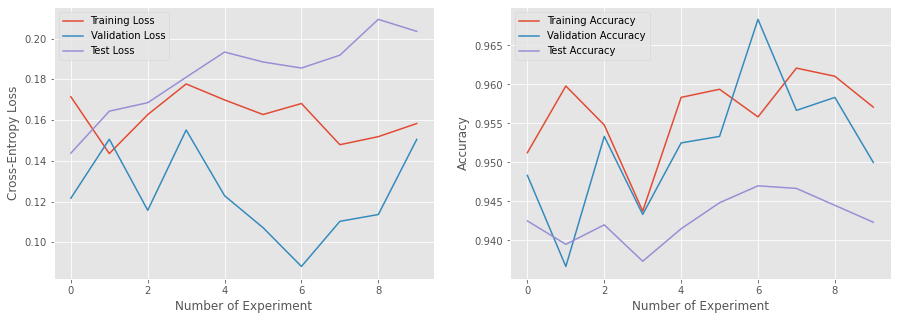

In [84]:
plt.subplots(figsize=(15,5))

plt.subplot(121)
plt.plot(train_loss,label='Training Loss')
plt.plot(val_loss,label='Validation Loss')
plt.plot(test_loss,label='Test Loss')
plt.xlabel('Number of Experiment')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

plt.subplot(122)
plt.plot(train_acc,label='Training Accuracy')
plt.plot(val_acc,label='Validation Accuracy')
plt.plot(test_acc,label='Test Accuracy')
plt.xlabel('Number of Experiment')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## ANN Results

Belwo the results for the ANN are generated.

In [85]:
f = pd.get_dummies(features)

model = Sequential()

model.add(Dense(15, activation='relu')) # len(x_wd.T)
model.add(Dropout(0.01))
model.add(Dense(2, activation='softmax'))
model.add(Dropout(0.01))
opt = tf.keras.optimizers.Adam(learning_rate=0.002) #5e-4

x_train, x_test, y_train, y_test = train_test_split(x_wd,f, test_size = 0.2, shuffle=True)

x_train_tf = tf.convert_to_tensor(x_train)
x_test_tf = tf.convert_to_tensor(x_test)
y_train_tf = tf.convert_to_tensor(y_train)
y_test_tf = tf.convert_to_tensor(y_test)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
history = model.fit(x_train_tf, y_train_tf,validation_data=(x_test_tf,y_test_tf), epochs=400, batch_size=50)

Epoch 1/400
96/96 [==============================] - 1s 6ms/step - loss: 3.5304 - accuracy: 0.5209 - val_loss: 0.6240 - val_accuracy: 0.6492
Epoch 2/400
96/96 [==============================] - 0s 3ms/step - loss: 0.6539 - accuracy: 0.6970 - val_loss: 0.4894 - val_accuracy: 0.7992
Epoch 3/400
96/96 [==============================] - 0s 3ms/step - loss: 0.5554 - accuracy: 0.8135 - val_loss: 0.4246 - val_accuracy: 0.8542
Epoch 4/400
96/96 [==============================] - 0s 3ms/step - loss: 0.4907 - accuracy: 0.8404 - val_loss: 0.3820 - val_accuracy: 0.8575
Epoch 5/400
96/96 [==============================] - 0s 3ms/step - loss: 0.4327 - accuracy: 0.8555 - val_loss: 0.3482 - val_accuracy: 0.8717
Epoch 6/400
96/96 [==============================] - 0s 3ms/step - loss: 0.4323 - accuracy: 0.8561 - val_loss: 0.3246 - val_accuracy: 0.8750
Epoch 7/400
96/96 [==============================] - 0s 3ms/step - loss: 0.4367 - accuracy: 0.8561 - val_loss: 0.3070 - val_accuracy: 0.8875
Epoch 8/400
9

Epoch 59/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2217 - accuracy: 0.9413 - val_loss: 0.1518 - val_accuracy: 0.9400
Epoch 60/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2416 - accuracy: 0.9343 - val_loss: 0.1476 - val_accuracy: 0.9375
Epoch 61/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1953 - accuracy: 0.9377 - val_loss: 0.1471 - val_accuracy: 0.9392
Epoch 62/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2157 - accuracy: 0.9418 - val_loss: 0.1553 - val_accuracy: 0.9400
Epoch 63/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2009 - accuracy: 0.9428 - val_loss: 0.1457 - val_accuracy: 0.9408
Epoch 64/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2088 - accuracy: 0.9398 - val_loss: 0.1463 - val_accuracy: 0.9392
Epoch 65/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2152 - accuracy: 0.9384 - val_loss: 0.1647 - val_accuracy: 0.9292
Epoch 

96/96 [==============================] - 0s 2ms/step - loss: 0.2041 - accuracy: 0.9448 - val_loss: 0.1398 - val_accuracy: 0.9425
Epoch 117/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1874 - accuracy: 0.9548 - val_loss: 0.1497 - val_accuracy: 0.9308
Epoch 118/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1406 - accuracy: 0.9579 - val_loss: 0.1417 - val_accuracy: 0.9408
Epoch 119/400
96/96 [==============================] - 0s 3ms/step - loss: 0.2311 - accuracy: 0.9423 - val_loss: 0.1394 - val_accuracy: 0.9375
Epoch 120/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1531 - accuracy: 0.9561 - val_loss: 0.1372 - val_accuracy: 0.9408
Epoch 121/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1956 - accuracy: 0.9483 - val_loss: 0.1443 - val_accuracy: 0.9342
Epoch 122/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2085 - accuracy: 0.9466 - val_loss: 0.1416 - val_accuracy: 0.9417
Epoch 123/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1843 - accuracy: 0.9502 - val_loss: 0.1412 - val_accuracy: 0.9375
Epoch 174/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1624 - accuracy: 0.9538 - val_loss: 0.1530 - val_accuracy: 0.9400
Epoch 175/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1693 - accuracy: 0.9554 - val_loss: 0.1476 - val_accuracy: 0.9358
Epoch 176/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1645 - accuracy: 0.9529 - val_loss: 0.1443 - val_accuracy: 0.9400
Epoch 177/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1990 - accuracy: 0.9452 - val_loss: 0.1473 - val_accuracy: 0.9342
Epoch 178/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1743 - accuracy: 0.9517 - val_loss: 0.1450 - val_accuracy: 0.9375
Epoch 179/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1696 - accuracy: 0.9521 - val_loss: 0.1436 - val_accuracy: 0.9333
Epoch 180/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1556 - accuracy: 0.9547 - val_loss: 0.1642 - val_accuracy: 0.9275
Epoch 231/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1843 - accuracy: 0.9562 - val_loss: 0.1445 - val_accuracy: 0.9367
Epoch 232/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1910 - accuracy: 0.9483 - val_loss: 0.1528 - val_accuracy: 0.9275
Epoch 233/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1644 - accuracy: 0.9527 - val_loss: 0.1476 - val_accuracy: 0.9375
Epoch 234/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1635 - accuracy: 0.9551 - val_loss: 0.1543 - val_accuracy: 0.9350
Epoch 235/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1635 - accuracy: 0.9543 - val_loss: 0.1517 - val_accuracy: 0.9367
Epoch 236/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1640 - accuracy: 0.9549 - val_loss: 0.1445 - val_accuracy: 0.9342
Epoch 237/400

96/96 [==============================] - 0s 2ms/step - loss: 0.1614 - accuracy: 0.9495 - val_loss: 0.1416 - val_accuracy: 0.9408
Epoch 288/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1758 - accuracy: 0.9551 - val_loss: 0.1394 - val_accuracy: 0.9367
Epoch 289/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1988 - accuracy: 0.9466 - val_loss: 0.1455 - val_accuracy: 0.9333
Epoch 290/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1629 - accuracy: 0.9533 - val_loss: 0.1494 - val_accuracy: 0.9325
Epoch 291/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1657 - accuracy: 0.9541 - val_loss: 0.1524 - val_accuracy: 0.9392
Epoch 292/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1615 - accuracy: 0.9584 - val_loss: 0.1548 - val_accuracy: 0.9292
Epoch 293/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1536 - accuracy: 0.9597 - val_loss: 0.1567 - val_accuracy: 0.9333
Epoch 294/400

96/96 [==============================] - 0s 2ms/step - loss: 0.2076 - accuracy: 0.9511 - val_loss: 0.1501 - val_accuracy: 0.9358
Epoch 345/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1642 - accuracy: 0.9591 - val_loss: 0.1478 - val_accuracy: 0.9375
Epoch 346/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1908 - accuracy: 0.9510 - val_loss: 0.1472 - val_accuracy: 0.9392
Epoch 347/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1527 - accuracy: 0.9613 - val_loss: 0.1499 - val_accuracy: 0.9375
Epoch 348/400
96/96 [==============================] - 0s 3ms/step - loss: 0.1575 - accuracy: 0.9576 - val_loss: 0.1425 - val_accuracy: 0.9400
Epoch 349/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1823 - accuracy: 0.9511 - val_loss: 0.1644 - val_accuracy: 0.9392
Epoch 350/400
96/96 [==============================] - 0s 4ms/step - loss: 0.1637 - accuracy: 0.9572 - val_loss: 0.1481 - val_accuracy: 0.9317
Epoch 351/400

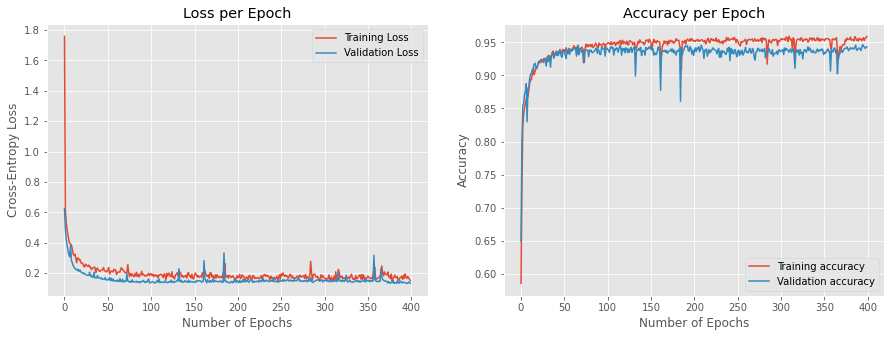

In [86]:
plt.subplots(figsize=(15,5))

plt.subplot(121)
plt.plot(history.history['loss'],label = 'Training Loss')
plt.plot(history.history['val_loss'],label = 'Validation Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'],label = 'Training accuracy')
plt.plot(history.history['val_accuracy'],label = 'Validation accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

plt.show()

In [87]:
yy_test = pd.get_dummies(yy)
results = model.evaluate(xx_dummy, yy_test, batch_size=128)
#y_hat = model.predict_classes(xx_dummy, verbose=1)
#y_hat_dummy = pd.get_dummies(y_hat)
print("test loss, test acc:", results)
#print(sklearn.metrics.f1_score(y_hat_dummy, yy_test,average='micro'))

47/47 [==============================] - 0s 2ms/step - loss: 0.1546 - accuracy: 0.9403
test loss, test acc: [0.15464027225971222, 0.9403333067893982]


In [88]:
results[0]

0.15464027225971222

## Below the results for the Support Vector Machine are Generated

The label is transformed such that unsatisfied or neutral passengers are coded as -1 and satisfied passenger are coded as 1. 

In [89]:
svm_y = np.empty((len(features),1))

for i in range(len(features)):
    if features.iloc[i] == 1:
        svm_y[i] = 1
    else:
        svm_y[i] = -1

svm_y.astype(int)
x_train, x_test, y_train, y_test = train_test_split(x_wd,svm_y, test_size = 0.2, shuffle=True)


clf = svm.SVC(kernel='rbf')
clf.fit(x_train, y_train)
print('Training Accuracy: ',clf.score(x_train, y_train))
print('Validation Accuracy: ',clf.score(x_test, y_test))

/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training Accuracy:  0.9466666666666667
Validation Accuracy:  0.9258333333333333


### Get results for the Test data

In [90]:
svm_y_test = np.empty((len(yy),1))

for i in range(len(yy)):
    if yy.iloc[i] == 1:
        svm_y_test[i] = 1
    else:
        svm_y_test[i] = -1

In [91]:
y_pred = clf.predict(xx_dummy)
print('Test Accuracy: ',clf.score(xx_dummy, svm_y_test))
print(sklearn.metrics.f1_score(y_pred, svm_y_test,average='micro'))

Test Accuracy:  0.9296666666666666
0.9296666666666666


## Results for the Random Forest Classifier

In [92]:
clf = RandomForestClassifier(max_depth=None, random_state=0)

x_train, x_test, y_train, y_test = train_test_split(x_wd,svm_y, test_size = 0.2, shuffle=True)

clf.fit(x_train, y_train)
print('Training Accuracy: ',clf.score(x_train, y_train))
print('Validation Accuracy: ',clf.score(x_test, y_test))

<ipython-input-92-658d8ea662f0>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(x_train, y_train)


Training Accuracy:  1.0
Validation Accuracy:  0.9508333333333333


In [93]:
y_pred = clf.predict(xx_dummy)
print('Test Accuracy: ',clf.score(xx_dummy, svm_y_test))
print(sklearn.metrics.f1_score(y_pred, svm_y_test))

Test Accuracy:  0.9495
0.940083053193593


## Results for AdaBoost

In [94]:
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(x_train, y_train)
y_pred = clf.predict(xx_dummy)
print('Training Accuracy: ',clf.score(x_train, y_train))
print('Validation Accuracy: ',clf.score(x_test, y_test))
print('Test Accuracy: ',clf.score(xx_dummy, yy))
print(sklearn.metrics.f1_score(y_pred, svm_y_test))

/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training Accuracy:  0.938125
Validation Accuracy:  0.9258333333333333
Test Accuracy:  0.38816666666666666
0.9192816262088019


## Results for Naive Bayes

In [95]:
clf = GaussianNB()
clf.fit(x_train, y_train)
y_pred = clf.predict(xx_dummy)
print('Training Accuracy: ',clf.score(x_train, y_train))
print('Validation Accuracy: ',clf.score(x_test, y_test))
print('Test Accuracy: ',clf.score(xx_dummy, yy))
print(sklearn.metrics.f1_score(y_pred, svm_y_test))

Training Accuracy:  0.8702083333333334
Validation Accuracy:  0.8766666666666667
Test Accuracy:  0.3536666666666667
0.8328100470957613


/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


## Results for QDA

In [96]:
clf = QDA()
clf.fit(x_train, y_train)
print('Training Accuracy: ',clf.score(x_train, y_train))
print('Validation Accuracy: ',clf.score(x_test, y_test))
print('Test Accuracy: ',clf.score(xx_dummy, yy))

Training Accuracy:  0.681875
Validation Accuracy:  0.675
Test Accuracy:  0.2765


/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


## Results for Logistic Regression

In [97]:
x_train, x_test, y_train, y_test = train_test_split(x_wd,features, test_size = 0.2, shuffle=True)
clf = LogisticRegression(random_state=0,max_iter=500).fit(x_train, y_train)
y_pred = clf.predict(xx_dummy)
print('Training Accuracy: ',clf.score(x_train, y_train))
print('Validation Accuracy: ',clf.score(x_test, y_test))
print('Test Accuracy: ',clf.score(xx_dummy, yy))
print(sklearn.metrics.f1_score(y_pred, yy))

Training Accuracy:  0.879375
Validation Accuracy:  0.8825
Test Accuracy:  0.867
0.841288782816229
